# Regression with a Tabular Media Campaign Cost Dataset
(https://www.kaggle.com/competitions/playground-series-s3e11/overview/description)

Import necessary packages.

Download datasets.

Train and test datasets are synthetically generated from real-world data, oroginal dataset is also downloaded in variable original. Train, test and original datasets have the same set of features.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection, metrics, ensemble, tree
import xgboost  as xgb
from pathlib import Path
from sklearn.utils import shuffle
import catboost as cb
from itertools import product

In [4]:
data_dir = Path().resolve()

train = pd.read_csv('/kaggle/input/playground-series-s3e11/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s3e11/test.csv', index_col='id')
original = pd.read_csv('/kaggle/input/media-campaign-cost-prediction/train_dataset.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e11/sample_submission.csv', index_col='id')

In [3]:
train.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
id,,,,,,,,,,,,,,,,
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


In [4]:
original.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,2.68,2.0,1.0,0.0,2.0,6.30,1.0,0.0,22.0,30584.0,1.0,1.0,1.0,1.0,1.0,79.59
1,5.73,3.0,5.0,5.0,3.0,18.70,1.0,0.0,30.0,20319.0,0.0,0.0,0.0,0.0,0.0,118.36
2,2.62,2.0,1.0,1.0,1.0,9.21,0.0,0.0,9.0,20319.0,0.0,0.0,0.0,0.0,0.0,67.20
3,11.73,3.0,1.0,1.0,3.0,10.90,1.0,1.0,15.0,23112.0,1.0,1.0,1.0,1.0,1.0,60.87
4,4.82,2.0,1.0,1.0,3.0,8.15,0.0,0.0,7.0,38382.0,0.0,0.0,0.0,0.0,0.0,86.79


# Exploratory Data Analysis

Examine if the data has any null or blank values

In [5]:
print("Train:\n")
print(train.info())
print("\nTest:\n")
print(test.info())
print("\nOriginal dateset:\n")
print(original.info())

Train:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360336 entries, 0 to 360335
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   store_sales(in millions)    360336 non-null  float64
 1   unit_sales(in millions)     360336 non-null  float64
 2   total_children              360336 non-null  float64
 3   num_children_at_home        360336 non-null  float64
 4   avg_cars_at home(approx).1  360336 non-null  float64
 5   gross_weight                360336 non-null  float64
 6   recyclable_package          360336 non-null  float64
 7   low_fat                     360336 non-null  float64
 8   units_per_case              360336 non-null  float64
 9   store_sqft                  360336 non-null  float64
 10  coffee_bar                  360336 non-null  float64
 11  video_store                 360336 non-null  float64
 12  salad_bar                   360336 non-null  float64
 13  prepar

No null values in the datasets.

Let's check the datasets for duplicates

In [6]:
print('Quantaty of duplicated rows in train: ', train[train.duplicated(keep=False)].shape[0])
print('Quantaty of duplicated rows in initial dataset: ', original[original.duplicated(keep=False)].shape[0])
print('Quantaty of duplicated rows in test: ', test[test.duplicated(keep=False)].shape[0])

Quantaty of duplicated rows in train:  0
Quantaty of duplicated rows in initial dataset:  70
Quantaty of duplicated rows in test:  0


There are duplicates in the original dataset, let's drop them.

In [8]:
original = original.drop(index= original[original.duplicated(keep='first')].index.to_list())

### Distribution comparison

In [7]:
print('Feature', ' '*20, 'Number of different values')
print('***** Train *****')
print(train.nunique())
print('***** Test *****')
print(test.nunique())
print('***** Original *****')
print(original.nunique())

Feature                      Number of different values
***** Train *****
store_sales(in millions)      1044
unit_sales(in millions)          6
total_children                   6
num_children_at_home             6
avg_cars_at home(approx).1       5
gross_weight                   384
recyclable_package               2
low_fat                          2
units_per_case                  36
store_sqft                      20
coffee_bar                       2
video_store                      2
salad_bar                        2
prepared_food                    2
florist                          2
cost                           328
dtype: int64
***** Test *****
store_sales(in millions)      1035
unit_sales(in millions)          6
total_children                   6
num_children_at_home             6
avg_cars_at home(approx).1       5
gross_weight                   380
recyclable_package               2
low_fat                          2
units_per_case                  36
store_sqft           

In [8]:
train.shape

(360336, 16)

As we can see from number of different values for features in train set, all features and target value 'cost' are discrete. 

In [9]:
#Features with more than 10 values:
long_f = ['store_sales(in millions)',  'gross_weight', 'units_per_case', 'store_sqft', 'cost']
#Features with less than 10 values:
short_f = ['total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'unit_sales(in millions)',
         'recyclable_package', 'low_fat', 'coffee_bar', 'video_store', 'salad_bar',
         'prepared_food', 'florist']
#Boolean features:
bool_f = ['recyclable_package', 'low_fat', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']
cat_f = ['unit_sales', 'total_children',
       'num_children_at_home', 'avg_cars_at home(approx).1',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft',
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']

**Feature description:**
* store_sales(in millions) - store_sales(in million dollars)
* unit_sales(in millions) - unit_sales(in millions) in stores quantity
* Total_children - total children in home
* avg_cars_at home(approx) - avg_cars_at home(approx)
* Num_children_at_home - num_children_at_home as per customers filled details
* Gross_weight - gross_weight of item
* Recyclable_package - food item is recyclable_package
* Low_fat - low_fat food item is low fat
* Units_per_case - units/case units available in each store shelves
* Store_sqft - store area available in sqft
* Coffee_bar - coffee bar available in store
* Video_store - video store/gaming store available
* Salad_bar - salad bar available in store
* Prepared_food - food prepared available in store
* Florist - flower shelves available in store
* Cost - cost on acquiring a customers in dollars

In [10]:
def add_bar_labels(ax, df):
    col_tot = df.shape[0]
    for p in ax.patches:
        percents = p.get_width()/col_tot*100
    #     print(f'val = {percents:.2f}%, coords = ({p.get_x()}, {p.get_y()}), height = {p.get_height()}, width = {p.get_width()}')
        x = p.get_x() + p.get_width() + 5
        y = p.get_y() + p.get_height()/2 + 0.05
        ax.annotate(f'{percents:.2f}%', (x, y), size = 10)

In [94]:
def short_features_dist(df, short_f, target):
    fig, ax = plt.subplots(len(short_f), 2, figsize = (len(short_f)*3, len(short_f)*4), dpi=150)
    for i, col in enumerate(short_f):
        sns.countplot(data=df, y=df[col], ax = ax[i][0], palette = "Blues")
        sns.boxplot(data=df, x=df[col], y =df[target] , ax = ax[i][1], palette = "Blues" )
        add_bar_labels(ax = ax[i][0], df = df)
        ax[i][0].set_title(f'{col}', fontweight='bold', fontsize = 14, )
        ax[i][1].set_title(f'{col}', fontweight='bold', fontsize = 14, )
        ax[i][0].set(xlabel=None)
        ax[i][1].set(xlabel=None)

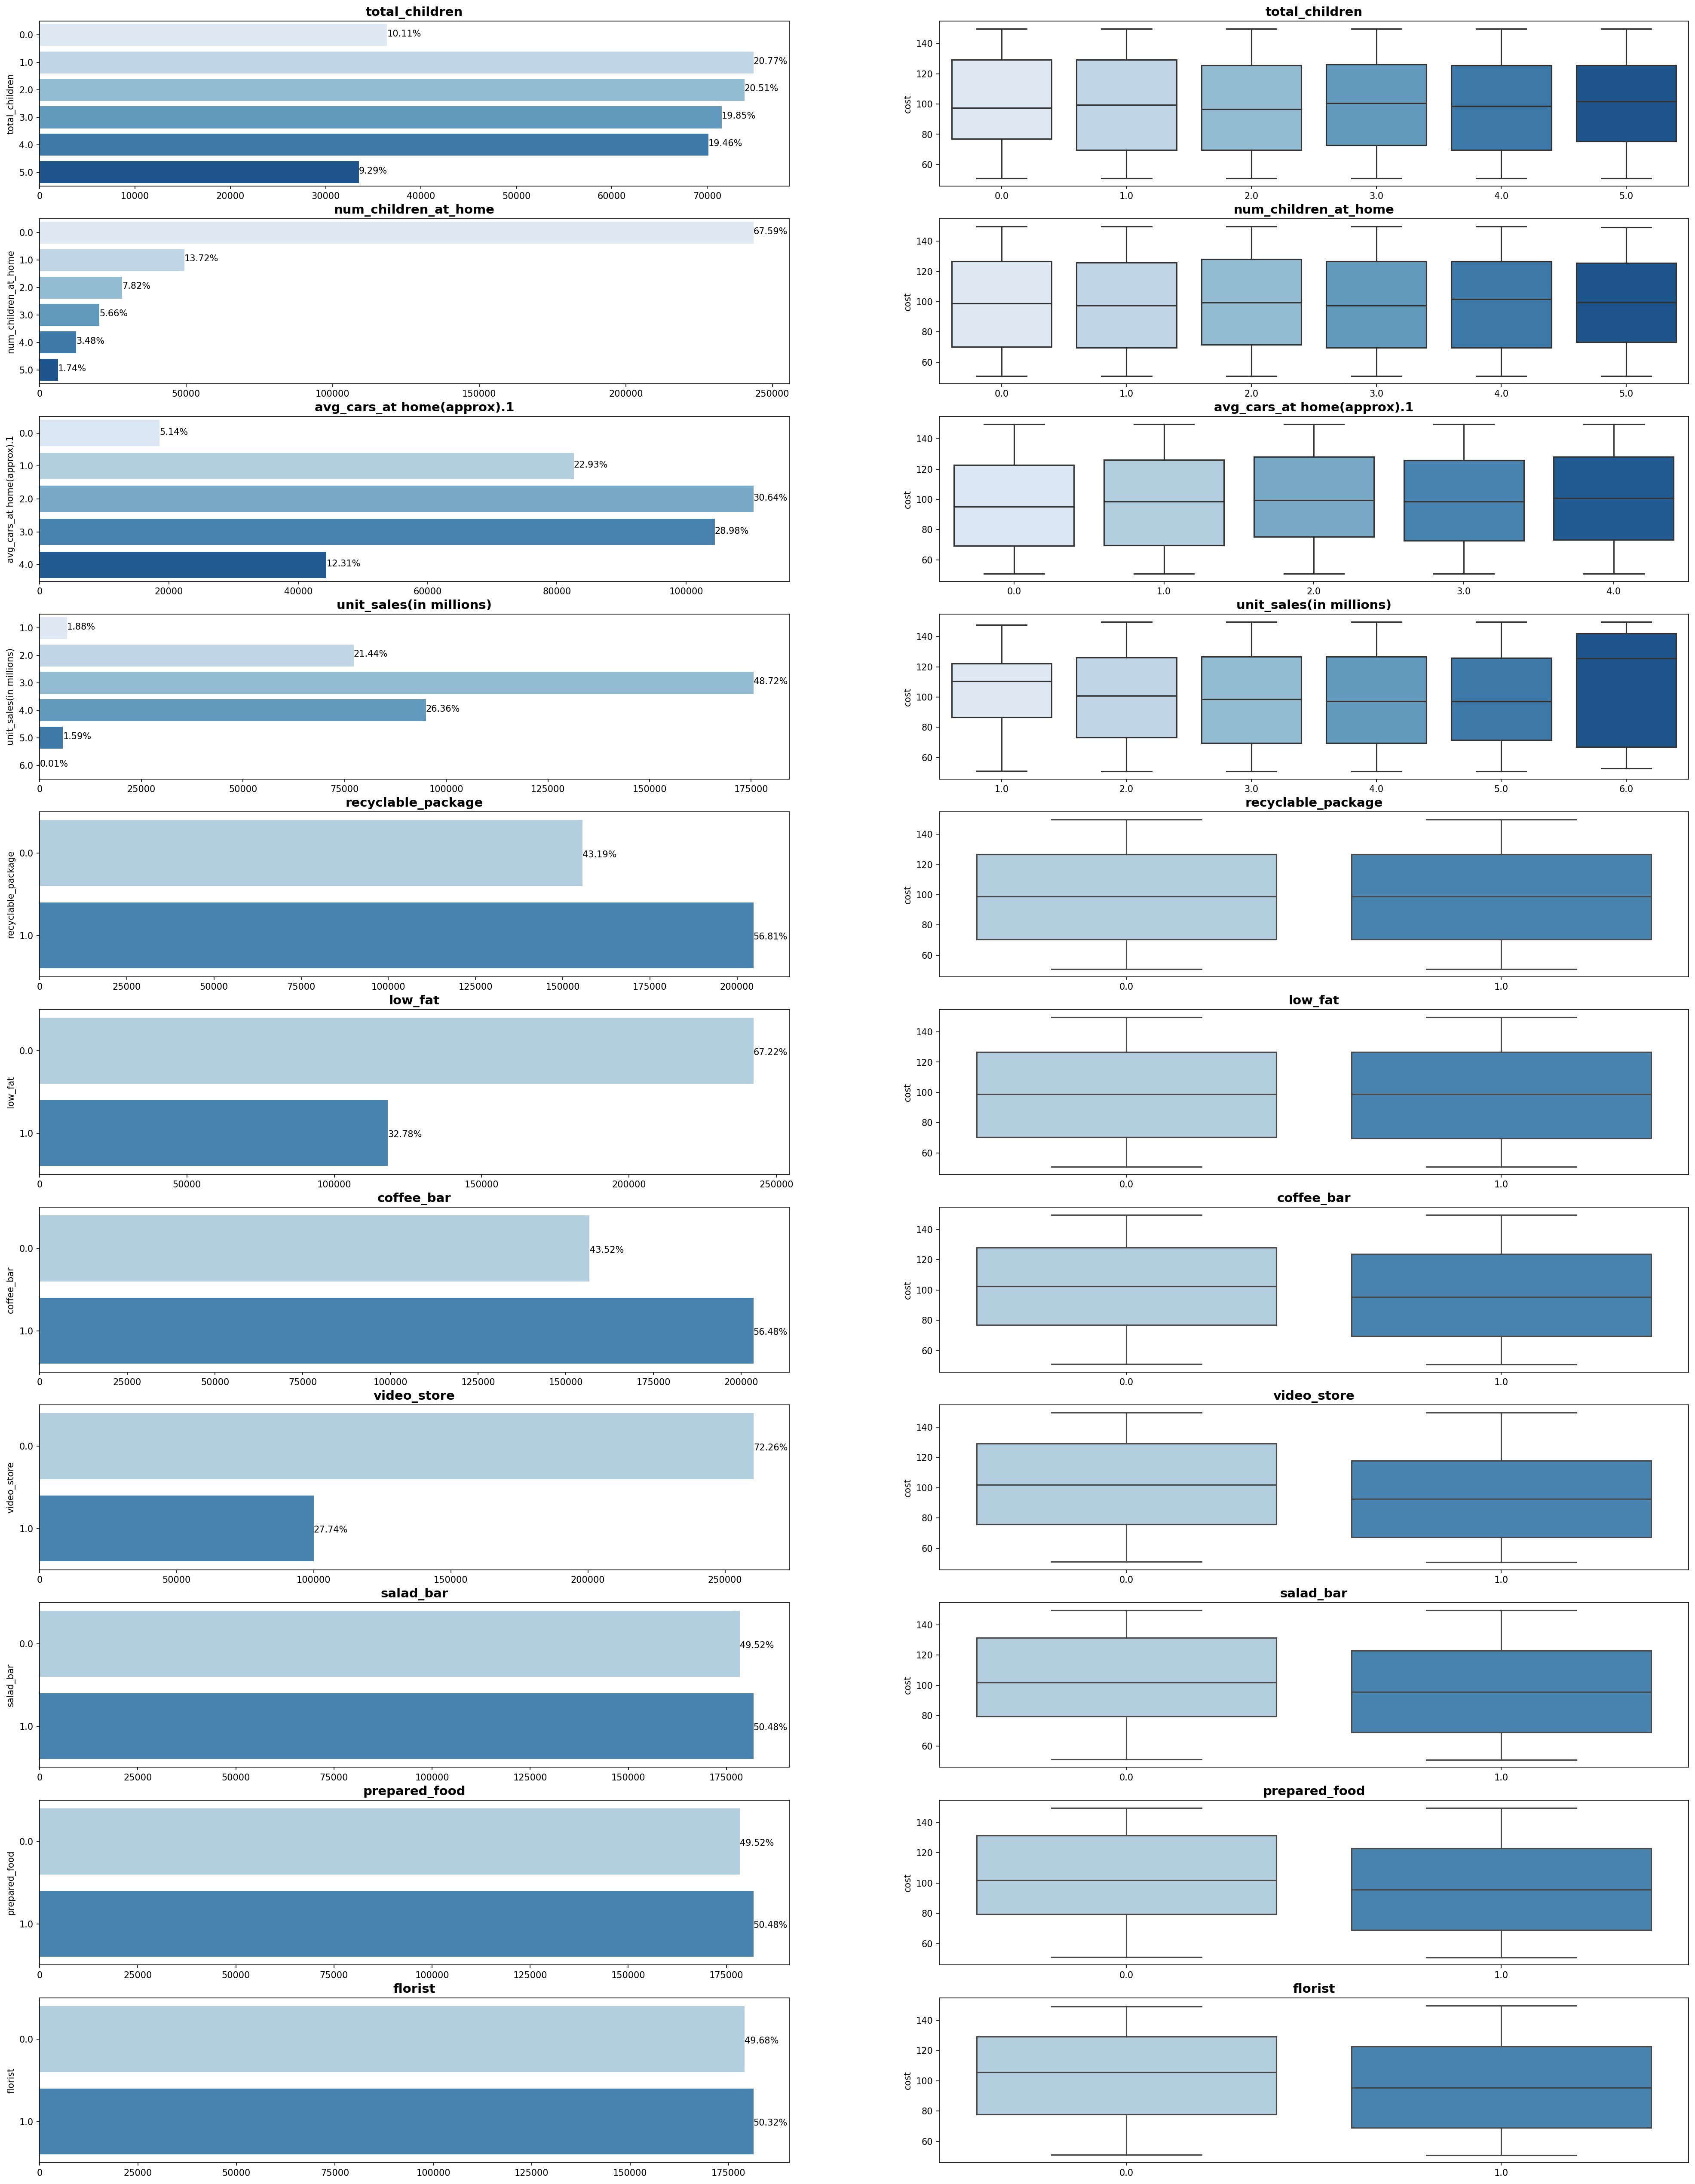

In [95]:
short_features_dist(train, short_f, 'cost')

* As we anticipated, presentce of some additional shops like 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist' reduces marketing costs. 
* At first glance 'recyclable_package', 'low_fat' have no influence on marketing costs.

**Idea:** try to reduce number of fearuters, some of them might be noisy or correlated

In [96]:
def long_features_dist(df, long_f):
    fig, ax = plt.subplots(len(long_f), 2, figsize = (len(long_f)*3, len(long_f)*4), dpi=150)
    for i, col in enumerate(long_f):
        sns.histplot(data = df, x=col, ax = ax[i][0], bins=100)
        sns.boxplot(data = df, x=col, ax = ax[i][1])
        ax[i][0].set_title(f'{col}', fontweight='bold', fontsize = 14, )
        ax[i][1].set_title(f'{col}', fontweight='bold', fontsize = 14, )
        ax[i][0].set(xlabel=None)
        ax[i][1].set(xlabel=None)

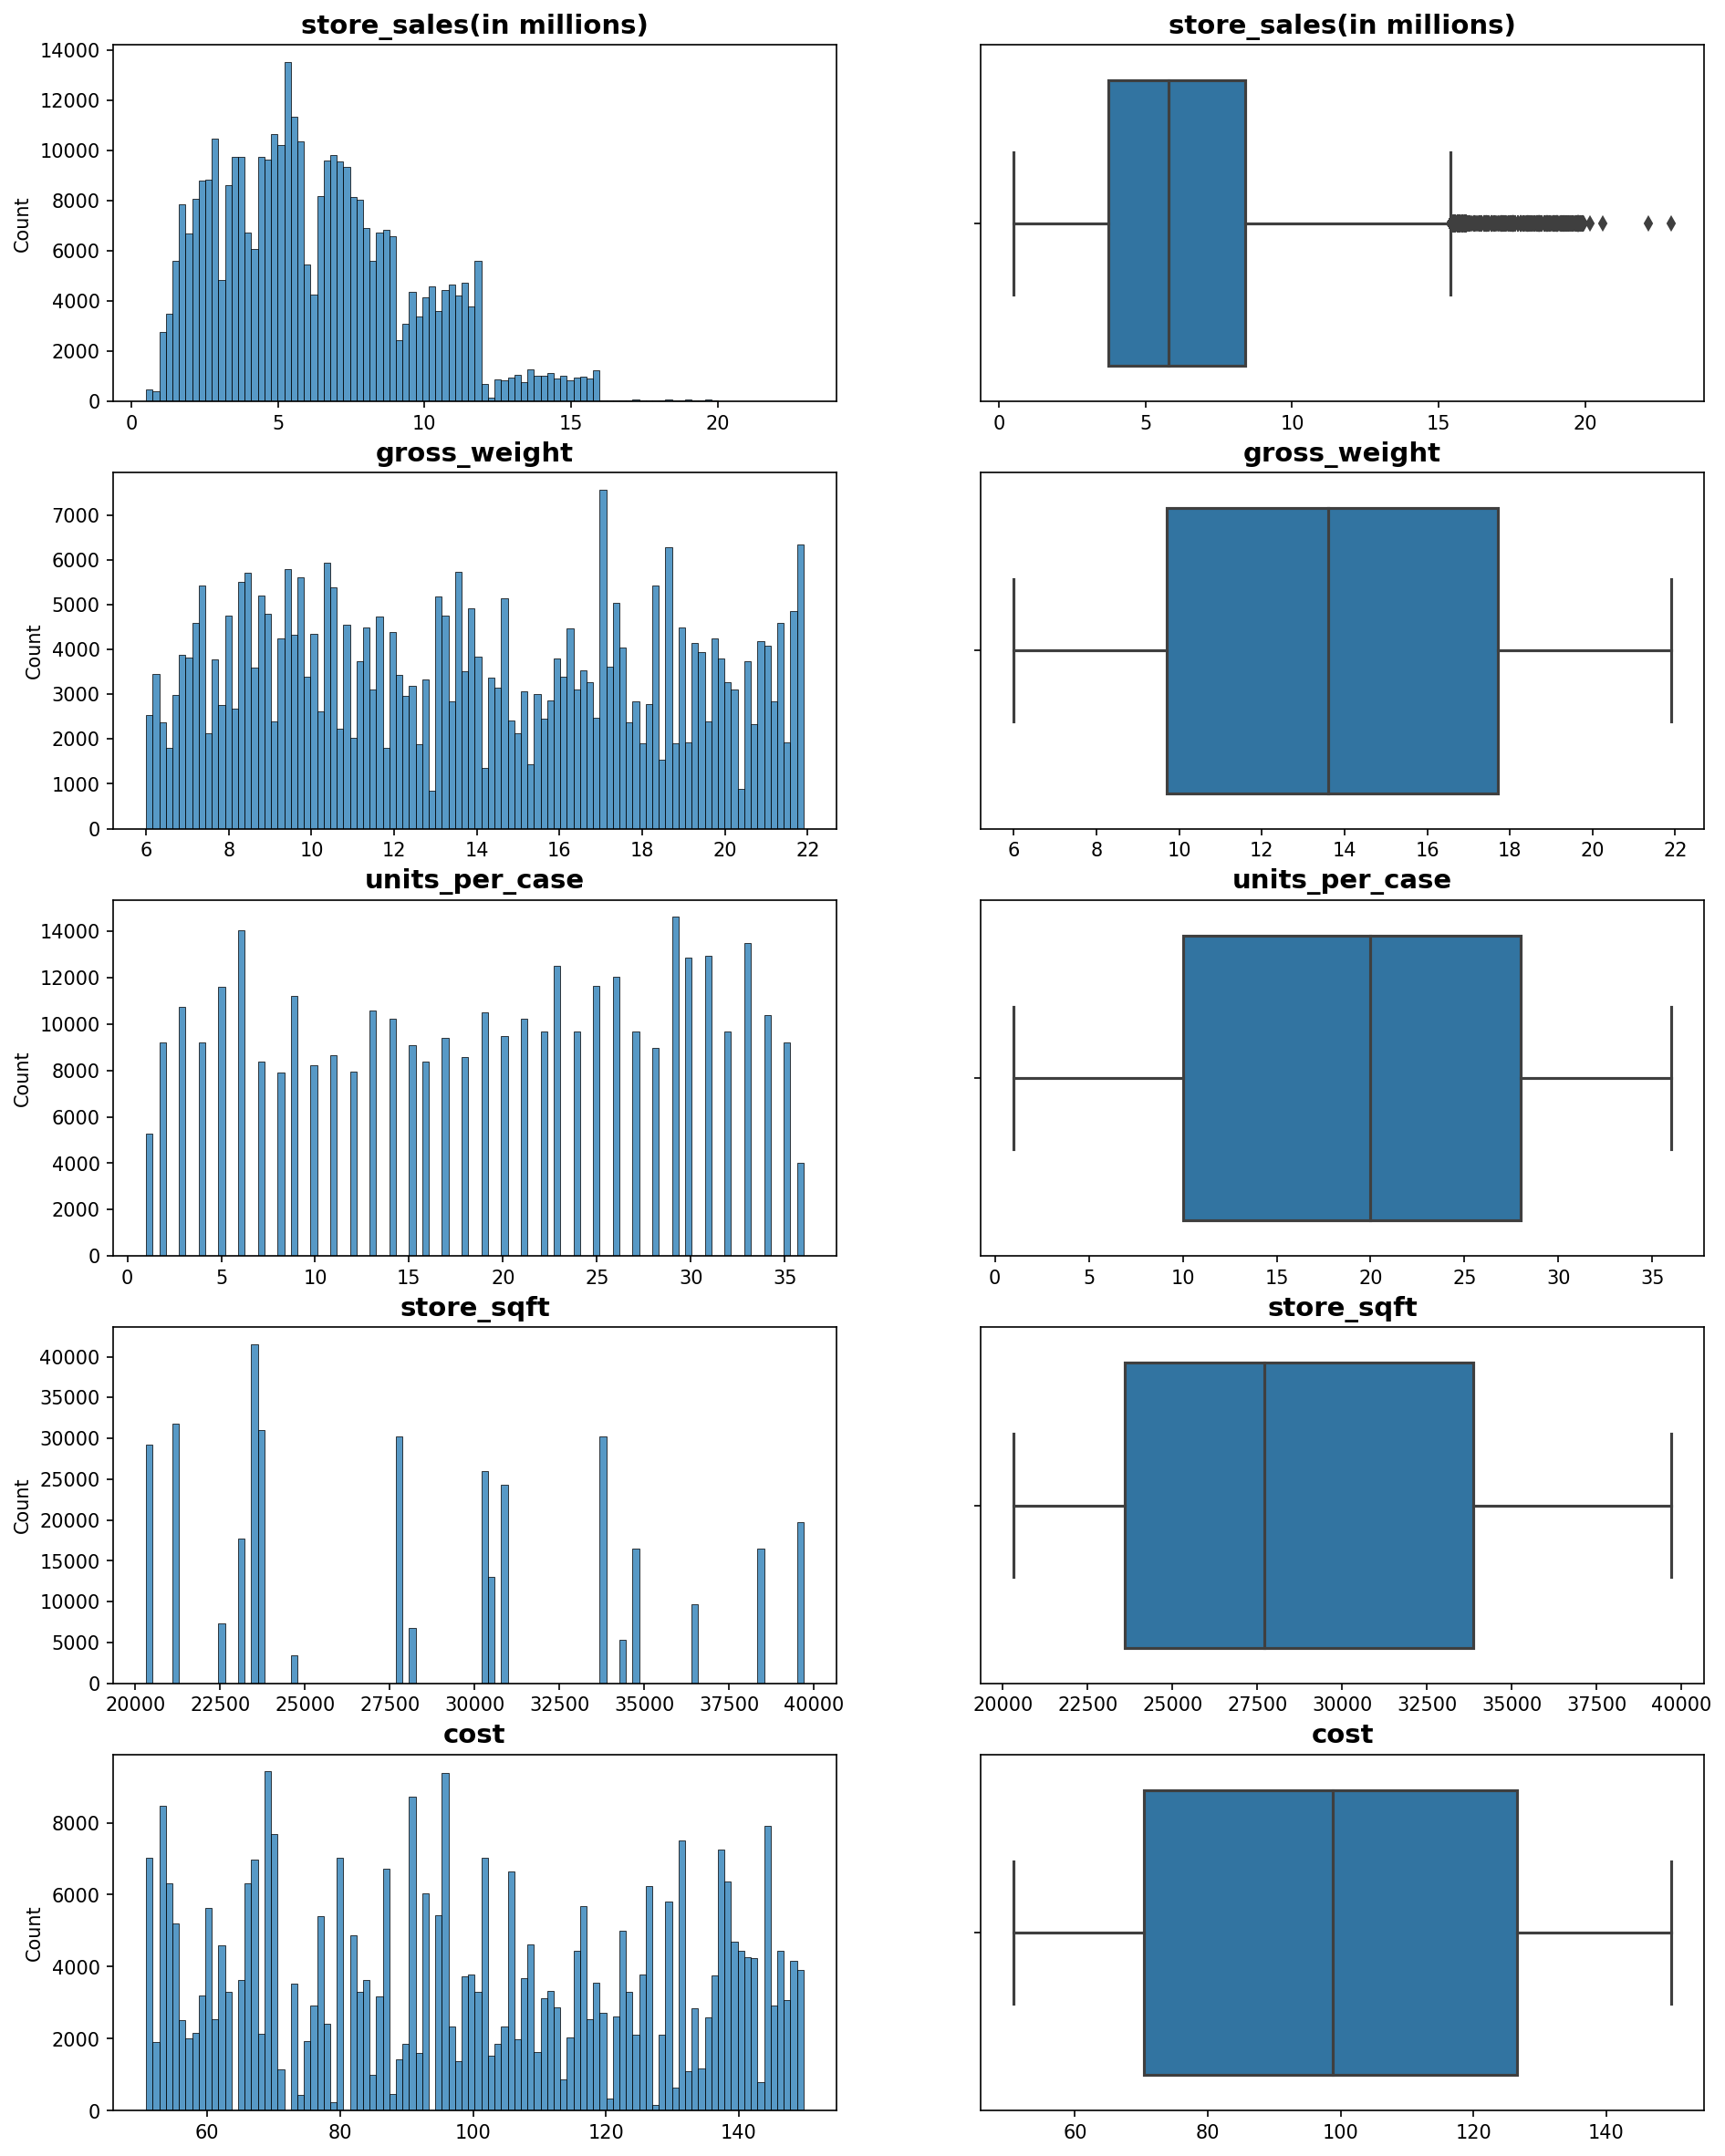

In [97]:
long_features_dist(train, long_f)

In [115]:
for col in ['store_sqft', 'units_per_case']:
    tr = set(train[col].unique())
    ts = set(test[col].unique())
    orig = set(original[col].unique())
    print(f'{col} Difference between test and train:', len(tr.symmetric_difference(ts)))
    print(f'{col} Difference between original and train:', len(orig.symmetric_difference(tr)))

store_sqft Difference between test and train: 0
store_sqft Difference between original and train: 0
units_per_case Difference between test and train: 0
units_per_case Difference between original and train: 0


As it's not so many unigue values in 'store_sqft' and 'units_per_case' features, and there is no new values in test or original datasets.

**Idea:** convert 'store_sqft'  and 'units_per_case' into set of binary features.

### Generated vs. initial datasets

In [36]:
def comparison(df1, df2, df3, long_f):
    fig, ax = plt.subplots(len(long_f), 2, figsize = (len(long_f)*3, len(long_f)*4), dpi=150)
    for i, col in enumerate(long_f):
        sns.kdeplot(data = df1, x=col, ax = ax[i][0], label = 'train')
        sns.kdeplot(data = df2, x=col, ax = ax[i][0], label = 'original')
        sns.kdeplot(data = df3, x=col, ax = ax[i][0], label = 'test')
        
        t = pd.concat([df1[col], df2[col], df3[col]], axis = 1)
        t.columns = ['train', 'original', 'test']
        
        sns.boxplot(data = t, ax = ax[i][1])
        
        ax[i][0].set_title(f'{col}', fontweight='bold', fontsize = 14, )
        ax[i][1].set_title(f'{col}', fontweight='bold', fontsize = 14, )
        ax[i][0].tick_params(axis="x", labelsize=8)
        ax[i][1].tick_params(axis="x", labelsize=8)
        ax[i][0].tick_params(axis="y", labelsize=8)
        ax[i][1].tick_params(axis="y", labelsize=8)
        
        ax[i][0].set(xlabel=None, ylabel=None)
        ax[i][1].set(xlabel=None, ylabel=None)
        ax[i][0].legend(fontsize=10)

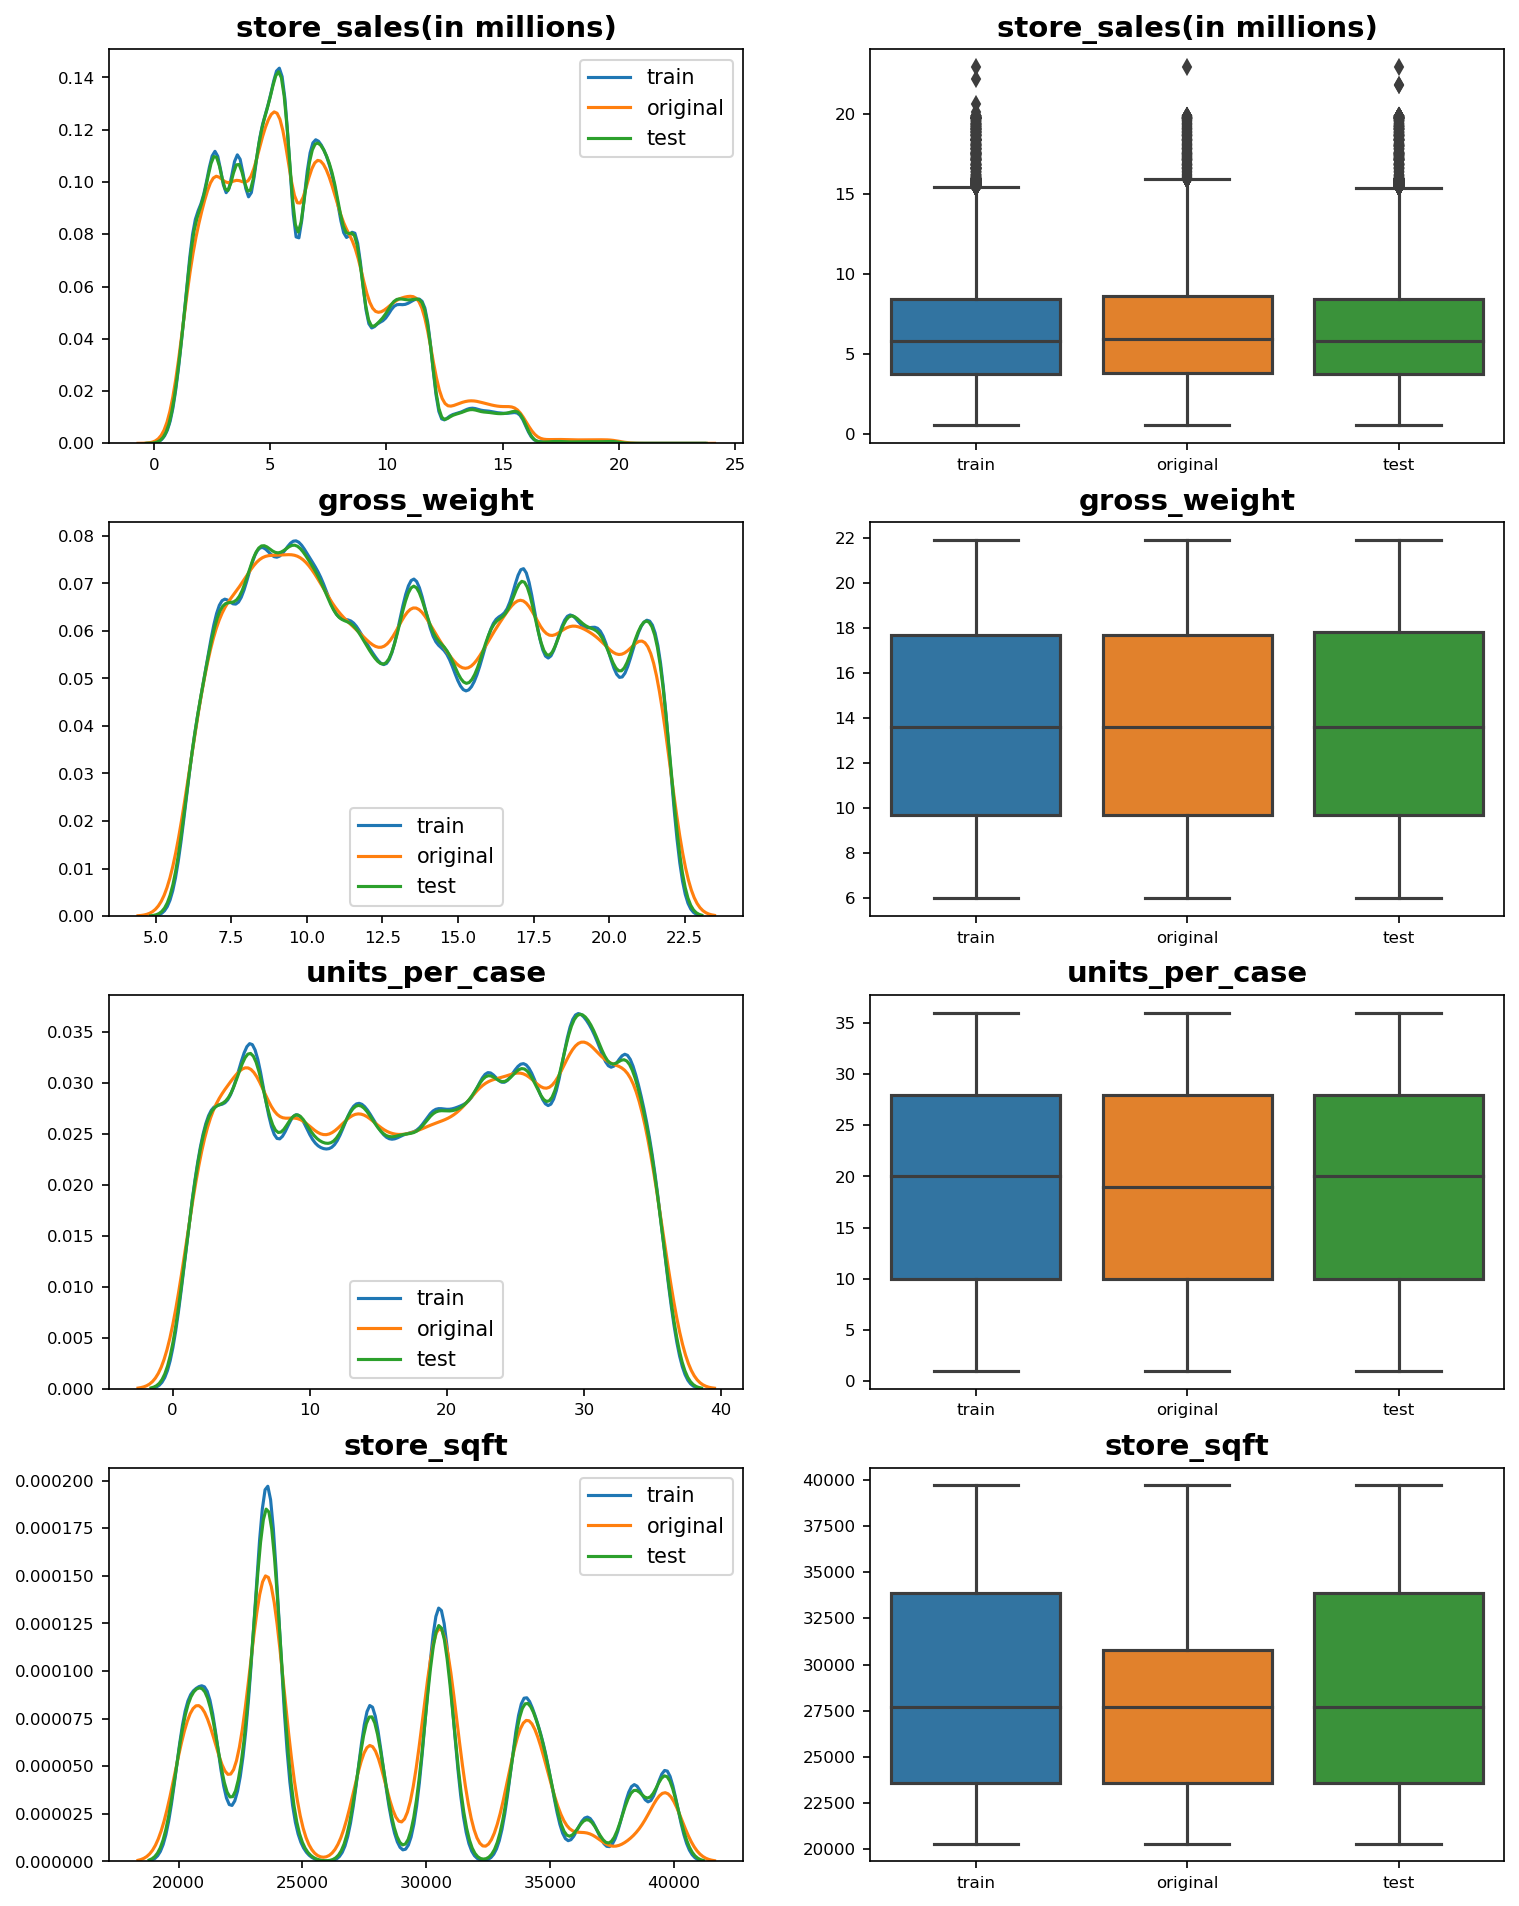

In [37]:
comparison(train, original, test, long_f[:-1])

In [52]:
def cat_comparison(df1, df2, df3, short_f):
    fig, ax = plt.subplots(len(short_f), 2, figsize = (len(short_f)*3, len(short_f)*9), dpi=150)
    for i, col in enumerate(short_f):
        sns.countplot(data=df1, y=df1[col], ax = ax[i][0], palette = "Blues")
        
#         sns.boxplot(data=df, x=df[col], y =df[target] , ax = ax[i][1], palette = "Blues" )
        t = pd.concat([df1[col], df2[col], df3[col]], axis = 1)
        t.columns = ['train', 'init', 'test']
        
        sns.boxplot(data = t , ax = ax[i][1])
        
        add_bar_labels(ax = ax[i][0], df = t)
        ax[i][0].set_title(f'{col}', fontweight='bold', fontsize = 14, )
        ax[i][1].set_title(f'{col}', fontweight='bold', fontsize = 14, )
        ax[i][0].set(xlabel=None)
        ax[i][1].set(xlabel=None)

In [53]:
cat_comparison(train, original, test, short_f)

### Correlation

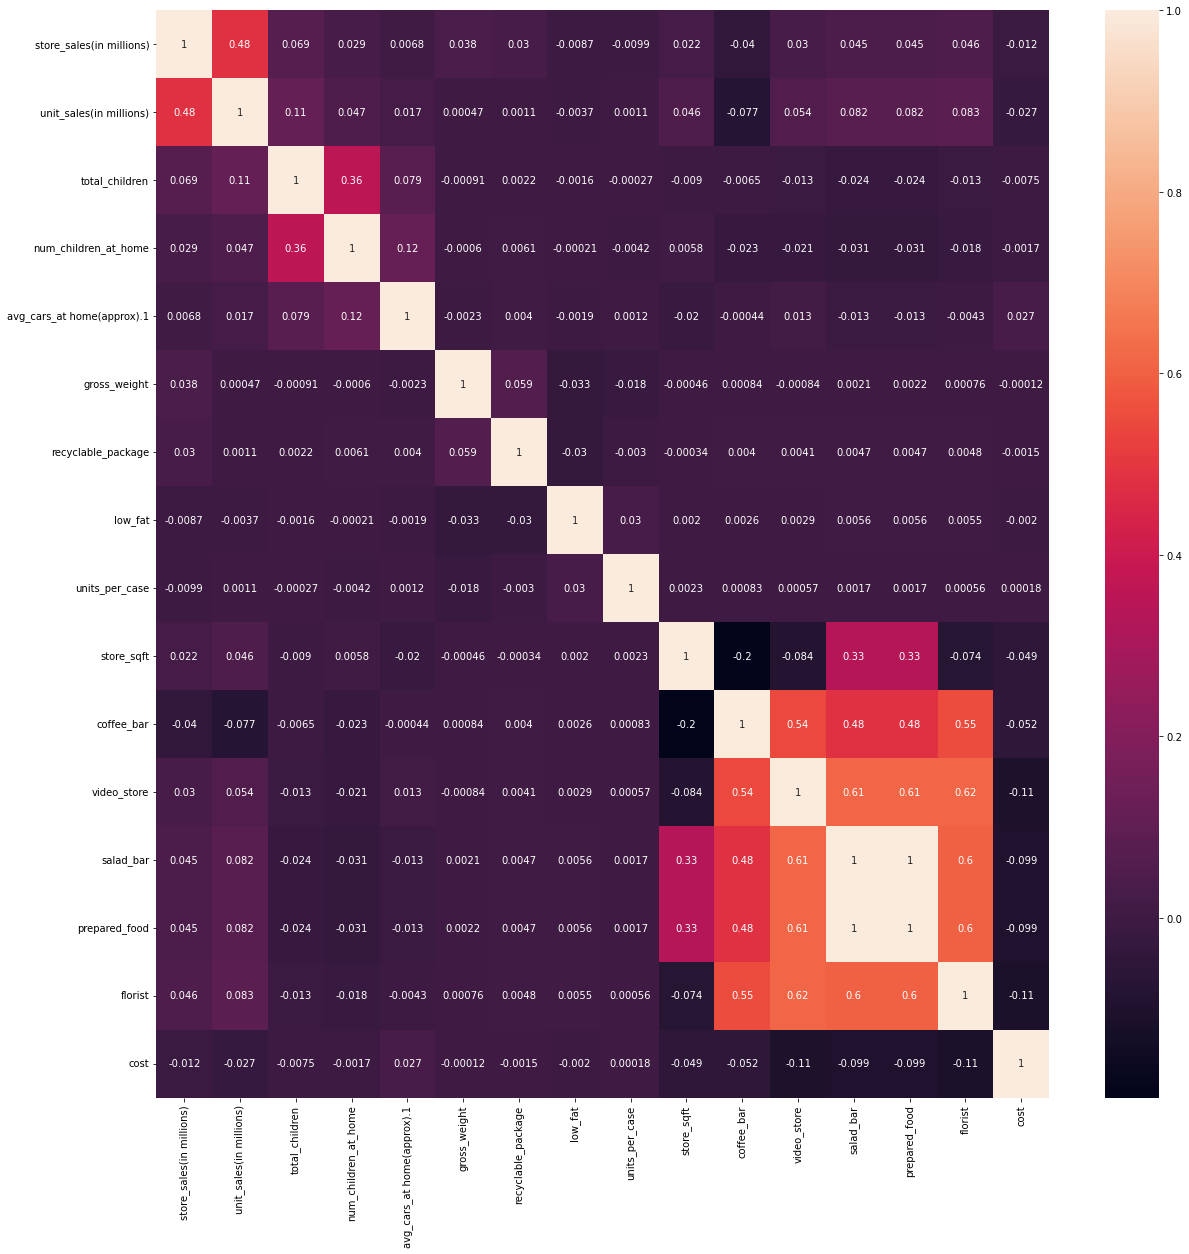

In [60]:
ax, fig = plt.subplots(1, 1, figsize=(20,20))
sns.heatmap(train.corr(), annot=True, cbar=True)
plt.show()

* 'salad_bar' and 'prepared_food' are highly correlated, it can be useful to drop one of them.
*  Boolean features are correlated with each other.

**Key takeaways:** Try to reduce the number of features

### Data Preprocessing

Competition scored metrics is Root Mean Squared Log Error, for convenience target value 'cost' will be transformed to $\log{(cost + 1)}$

In [11]:
X=train.iloc[:, :-1].copy()
y = np.log1p(train['cost'])

X_or=original.iloc[:, :-1].copy()
y_or = np.log1p(original['cost'])

X_t=test.copy()

In [12]:
X.rename(columns={'store_sales(in millions)':'store_sales',
                 'unit_sales(in millions)':'unit_sales'}, inplace=True)
X_or.rename(columns={'store_sales(in millions)':'store_sales',
                 'unit_sales(in millions)':'unit_sales'}, inplace=True)
X_t.rename(columns={'store_sales(in millions)':'store_sales',
                 'unit_sales(in millions)':'unit_sales'}, inplace=True)

In [13]:
for col in ['unit_sales', 'total_children',
       'num_children_at_home', 'avg_cars_at home(approx).1',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft',
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']:
    X[col] = X[col].astype('int')
    X_or[col] = X_or[col].astype('int')
    X_t[col] = X_t[col].astype('int')
    
for col in ['store_sales', 'gross_weight']:
    X[col] = X[col].astype('float32')
    X_or[col] = X_or[col].astype('float32')
    X_t[col] = X_t[col].astype('float32')
    
y = y.astype('float32')
y_or = y_or.astype('float32')

# Baseline models

At the begining we start with regression models with default parameters, as there is a mix of categorial and numerical features, it is worth to try logical methods as RandomForest, CatBoost, XGBoost. For parameters tunning Optuna is used, its calculations are not included in this NoteBook.

For more accurate comparison between models SEED is defined prio any calculations and is used for random_state where appropriate.

In [98]:
SEED = 21
# DataFrame to log all models results
model_results = pd.DataFrame([],
                        columns=['model', 
                                 'parameters',
                                 'RMSLE',
                                 'RMSLE_std',
                                 'datasets',
                                 'feat_eng',
                                 'comments'
                                ])

In [362]:
# function to evaluate models result and to prepare it for writing into model_results
def model_res_cv(X , y, model, X_or = X_or, 
                      cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=SEED),
                      param = 'default',
                      datasets = 0,
                      feat_eng = 'no',
                      comments = ''):
    '''
    Function evaluates model result and generate its description to add in model_results. 
    *****Parameters: *****
        X - train dataset
        y - target value
        model - model to evaluate
        X_or - original dataset, default: original dataset without target column and any transformations
        cv - cross validation strategy
        param - parameters used for model, default: 'default'
        datasets - indicator if to use only train dataset or train and original datasets; 0 - only train,
                    1 - train and original
        feat_eng - description of used feature engeneering
        comments - field to write comments about model and data, for CatBoost and XGBoost the field includes 
                    an array of best iteration for every launch
    *****Return: *****
    tuple (new, model)
        new - a line with model and datadescription that can be added in model_results
        model - last trained model
    '''
        
    scorings = ['neg_root_mean_squared_error'
               ]
    
    new = [str(model.__class__.__name__), str(param)]
    
    cat_iter = []
    xgb_iter = []
    
    for scor in scorings:

        t = []
        for (ind_train, ind_test) in cv.split(X, y):
            X_train, X_test = X.loc[ind_train], X.loc[ind_test]
            y_train, y_test = y.loc[ind_train], y.loc[ind_test]

            if datasets != 0:
                X_train = pd.concat([X_train, X_or[X.columns]], axis=0)
                y_train = pd.concat([y_train, y_or], axis=0)
                X_train, y_train = shuffle(X_train, y_train)


            if str(model.__class__.__name__)[:3] == 'Cat':
                model.fit(X_train, y_train, eval_set = (X_test, y_test), use_best_model = True, plot = False)
                cat_iter.append(model.get_best_iteration())
            if str(model.__class__.__name__)[:3] == 'XGB':
                model.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose = 0)
                xgb_iter.append(model.best_ntree_limit)

            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            t.append(metrics.mean_squared_error(y_test, y_pred, squared=False))


        new.append(np.mean(t))
        new.append(np.std(t))
    
    comments = comments + 'Iteration num:' + str(cat_iter) + str(xgb_iter)
    
    new.append('train' if datasets == 0 else 'train+original')
    new.append(feat_eng)
    new.append(comments)


    return new
       

In [364]:
models = [ensemble.RandomForestRegressor(random_state=SEED), 
          cb.CatBoostRegressor(loss_function = 'RMSE',verbose = False, random_state=SEED),
          xgb.XGBRegressor(random_state=SEED)]

for mod, datasets in product(models, [0, 1]):
    model_results.loc[len(model_results.index)] = model_res_cv(X, y,
                                                           model = mod,
                                                           datasets = datasets,
                                                          )

In [373]:
model_results

,model,parameters,RMSLE,RMSLE_std,datasets,feat_eng,comments
0,RandomForestRegressor,default,0.307587,0.000837,train,no,Iteration num:[][]
1,RandomForestRegressor,default,0.308496,0.000968,train+original,no,Iteration num:[][]
2,CatBoostRegressor,default,0.298391,0.000407,train,no,"Iteration num:[984, 940, 992, 726, 992][]"
3,CatBoostRegressor,default,0.298159,0.000410,train+original,no,"Iteration num:[984, 991, 948, 973, 996][]"
4,XGBRegressor,default,0.298799,0.000374,train,no,"Iteration num:[][100, 100, 100, 100, 100]"
5,XGBRegressor,default,0.298472,0.000526,train+original,no,"Iteration num:[][100, 100, 100, 100, 100]"


**Key takeaways**
* Best results are with CatBoost and XGBoost. As a next step parameters tunning for these model will be made.

# CatBoost 

The hyperparameters for CatBoost were tuned using Optuna. However, please note that the tuning process is not included in this notebook.

In [374]:
cb_param = { 'loss_function' : 'RMSE', 
           'eval_metric' : 'RMSE', 
           'early_stopping_rounds' : 100, 
           'max_depth' : 11,
           'iterations' : 250, 
           'learning_rate' : 0.09, 
           'l2_leaf_reg' : 0.17, 
           'bagging_temperature' : 0.93, 
           'cat_features' : cat_f, 
           'verbose' : 1000,
                        }


cb_est = cb.CatBoostRegressor(**cb_param)


model_results.loc[len(model_results.index)]=model_res_cv(X, y,
                                                         model=cb_est,
                                                         param = str(cb_param),
                                                         datasets=0,
                                                        )

model_results.loc[len(model_results.index)]=model_res_cv(X, y,
                                                         model=cb_est,
                                                         param = str(cb_param),
                                                         datasets=1,
                                                        )

0:	learn: 0.3145454	test: 0.3148987	best: 0.3148987 (0)	total: 605ms	remaining: 2m 30s
249:	learn: 0.2835483	test: 0.2945703	best: 0.2945167 (177)	total: 37s	remaining: 0us

bestTest = 0.2945166672
bestIteration = 177

Shrink model to first 178 iterations.
0:	learn: 0.3145454	total: 189ms	remaining: 47.1s
249:	learn: 0.2835483	total: 37.6s	remaining: 0us
0:	learn: 0.3146851	test: 0.3152185	best: 0.3152185 (0)	total: 157ms	remaining: 39.1s
249:	learn: 0.2843904	test: 0.2943440	best: 0.2943326 (217)	total: 40.7s	remaining: 0us

bestTest = 0.2943326031
bestIteration = 217

Shrink model to first 218 iterations.
0:	learn: 0.3146851	total: 132ms	remaining: 32.9s
249:	learn: 0.2843904	total: 39.8s	remaining: 0us
0:	learn: 0.3149073	test: 0.3141830	best: 0.3141830 (0)	total: 190ms	remaining: 47.4s
249:	learn: 0.2843198	test: 0.2938869	best: 0.2938869 (249)	total: 43.1s	remaining: 0us

bestTest = 0.2938868619
bestIteration = 249

0:	learn: 0.3149073	total: 161ms	remaining: 40.2s
249:	learn: 0.2

In [375]:
model_results

,model,parameters,RMSLE,RMSLE_std,datasets,feat_eng,comments
0,RandomForestRegressor,default,0.307587,0.000837,train,no,Iteration num:[][]
1,RandomForestRegressor,default,0.308496,0.000968,train+original,no,Iteration num:[][]
2,CatBoostRegressor,default,0.298391,0.000407,train,no,"Iteration num:[984, 940, 992, 726, 992][]"
3,CatBoostRegressor,default,0.298159,0.000410,train+original,no,"Iteration num:[984, 991, 948, 973, 996][]"
4,XGBRegressor,default,0.298799,0.000374,train,no,"Iteration num:[][100, 100, 100, 100, 100]"
5,XGBRegressor,default,0.298472,0.000526,train+original,no,"Iteration num:[][100, 100, 100, 100, 100]"
6,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294342,0.000477,train,no,"Iteration num:[177, 217, 249, 190, 241][]"
7,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294156,0.000390,train+original,no,"Iteration num:[230, 248, 212, 236, 196][]"


### Feature Importance for CatBoost

In [376]:
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=SEED)

tr_pool = cb.Pool(data = X_tr,
                  label= y_tr,
                  cat_features=cat_f)

eval_pool = cb.Pool(data = X_test,
                  label= y_test,
                  cat_features=cat_f)

cb_est.fit(tr_pool,
          eval_set=eval_pool,
          verbose=False,
          plot=False)

In [377]:
t = cb_est.get_feature_importance(data = tr_pool, type= 'LossFunctionChange')

feat_imp = pd.DataFrame([], index = X.columns.values)
feat_imp['Im'] = t

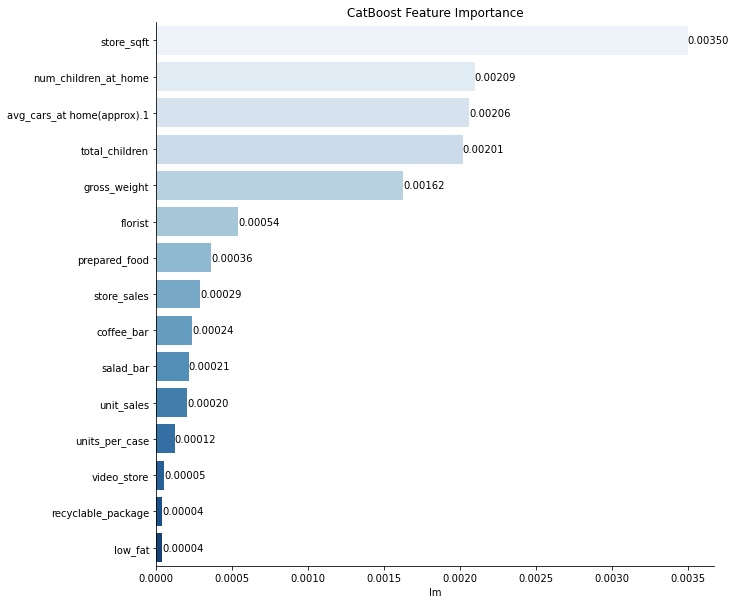

In [378]:
fig = plt.figure(figsize=(10, 10))
axes = sns.barplot(data = feat_imp.sort_values('Im', ascending=False),
            y = feat_imp.sort_values('Im', ascending=False).index.to_list(),
            x = 'Im',
            palette = "Blues")
axes.set(title = 'CatBoost Feature Importance')
# axes.set_xlim(0, 0.004)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
for i in axes.containers:
    axes.bar_label(i,fmt='%.5f')
plt.show()

From the bar plot, it can be seen that there are several gaps in feature importance: 0.00005, 0.0002, 0.0003, and 0.001. After selecting different sets of features using the aforementioned gaps as a threshold, it was found that the best result was achieved with a threshold of 0.0003. This threshold was used further in the notebook to select the best set of features, and CatBoost hyperparameters were tuned using Optuna for this set.

In [379]:
threshold = 0.0003
cb_feature = feat_imp[feat_imp.Im > threshold].index.to_list()

In [380]:
cb_feature

['total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'gross_weight',
 'store_sqft',
 'prepared_food',
 'florist']

In [381]:
cbfeat_param = { 'loss_function' : 'RMSE', 
           'eval_metric' : 'RMSE', 
           'early_stopping_rounds' : 100, 
           'max_depth' : 10,
           'iterations' : 1200, 
           'learning_rate' : 0.03, 
           'l2_leaf_reg' : 0.22, 
           'bagging_temperature' : 0.72, 
           'cat_features' : [x for x in cat_f if x in cb_feature], 
           'verbose' : False
                        }
cb_est = cb.CatBoostRegressor(**cbfeat_param)

model_results.loc[len(model_results.index)]=model_res_cv(X[cb_feature], y,
                                                         model=cb_est,
                                                         param = str(cbfeat_param),
                                                         datasets=0,
                                                         feat_eng = 'Used only: ' + str(cb_feature)
                                                        )

model_results.loc[len(model_results.index)]=model_res_cv(X[cb_feature], y,
                                                         model=cb_est,
                                                         param = str(cbfeat_param),
                                                         datasets=1,
                                                         feat_eng = 'Used only: ' + str(cb_feature)
                                                        )

In [382]:
model_results

,model,parameters,RMSLE,RMSLE_std,datasets,feat_eng,comments
0,RandomForestRegressor,default,0.307587,0.000837,train,no,Iteration num:[][]
1,RandomForestRegressor,default,0.308496,0.000968,train+original,no,Iteration num:[][]
2,CatBoostRegressor,default,0.298391,0.000407,train,no,"Iteration num:[984, 940, 992, 726, 992][]"
3,CatBoostRegressor,default,0.298159,0.000410,train+original,no,"Iteration num:[984, 991, 948, 973, 996][]"
4,XGBRegressor,default,0.298799,0.000374,train,no,"Iteration num:[][100, 100, 100, 100, 100]"
5,XGBRegressor,default,0.298472,0.000526,train+original,no,"Iteration num:[][100, 100, 100, 100, 100]"
6,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294342,0.000477,train,no,"Iteration num:[177, 217, 249, 190, 241][]"
7,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294156,0.000390,train+original,no,"Iteration num:[230, 248, 212, 236, 196][]"
8,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294010,0.000477,train,"Used only: ['total_children', 'num_children_at...","Iteration num:[1154, 1163, 1071, 953, 1008][]"
9,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.293862,0.000444,train+original,"Used only: ['total_children', 'num_children_at...","Iteration num:[1196, 1090, 1177, 893, 1075][]"


### Adding original dataset for CatBoost model

Upon examining the 'model_result' table, it is observed that the CatBoost model performance improves when the original dataset is included in the training data. Therefore, we will tune the model hyperparameters using the train+original dataset for training the model, along with the features selected during the previous step.

In [383]:
cbbest_param = { 'loss_function' : 'RMSE', 
           'eval_metric' : 'RMSE', 
           'early_stopping_rounds' : 100, 
           'max_depth' : 10,
           'iterations' : 2000,
           'learning_rate' : 0.02, 
           'l2_leaf_reg' : 0.49, 
           'bagging_temperature' : 0.92, 
           'cat_features' : [x for x in cat_f if x in cb_feature], 
           'verbose' : False
                        }
cb_est = cb.CatBoostRegressor(**cbbest_param)

model_results.loc[len(model_results.index)]=model_res_cv(X[cb_feature], y,
                                                         model=cb_est,
                                                         param = str(cbbest_param),
                                                         datasets=1,
                                                         feat_eng = 'Used only: ' + str(cb_feature)
                                                        )

In [390]:
x = model_results.loc[len(model_results.index)-1, 'comments'][15:-3].split(", ")
t = round(sum([int(d) for d in x])/len(x)/100)*100

cbbest_param.pop('early_stopping_rounds')
cbbest_param.pop('iterations')
cbbest_param['iterations'] = t

In [392]:
model_results

,model,parameters,RMSLE,RMSLE_std,datasets,feat_eng,comments
0,RandomForestRegressor,default,0.307587,0.000837,train,no,Iteration num:[][]
1,RandomForestRegressor,default,0.308496,0.000968,train+original,no,Iteration num:[][]
2,CatBoostRegressor,default,0.298391,0.000407,train,no,"Iteration num:[984, 940, 992, 726, 992][]"
3,CatBoostRegressor,default,0.298159,0.000410,train+original,no,"Iteration num:[984, 991, 948, 973, 996][]"
4,XGBRegressor,default,0.298799,0.000374,train,no,"Iteration num:[][100, 100, 100, 100, 100]"
5,XGBRegressor,default,0.298472,0.000526,train+original,no,"Iteration num:[][100, 100, 100, 100, 100]"
6,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294342,0.000477,train,no,"Iteration num:[177, 217, 249, 190, 241][]"
7,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294156,0.000390,train+original,no,"Iteration num:[230, 248, 212, 236, 196][]"
8,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294010,0.000477,train,"Used only: ['total_children', 'num_children_at...","Iteration num:[1154, 1163, 1071, 953, 1008][]"
9,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.293862,0.000444,train+original,"Used only: ['total_children', 'num_children_at...","Iteration num:[1196, 1090, 1177, 893, 1075][]"


### CatBoost result vs true value

In [393]:
cb_est = cb.CatBoostRegressor(**cbbest_param)
X_train = pd.concat([X[cb_feature], X_or[cb_feature]], axis=0)
y_train = pd.concat([y, y_or], axis=0)
cb_est.fit(X_train, y_train)
y_pr = cb_est.predict(X[cb_feature])

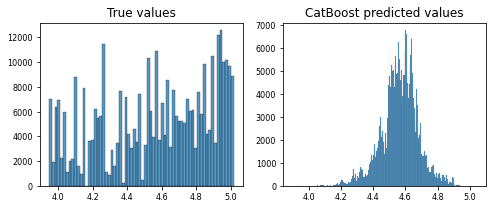

In [394]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3))
sns.histplot(y, ax = ax[0])
sns.histplot(y_pr, ax = ax[1])

# ax[0].set_title(f'{col}', fontweight='bold', fontsize = 14, )
# ax[i][1].set_title(f'{col}', fontweight='bold', fontsize = 14, )
ax[0].tick_params(axis="x", labelsize=8)
ax[1].tick_params(axis="x", labelsize=8)
ax[0].tick_params(axis="y", labelsize=8)
ax[1].tick_params(axis="y", labelsize=8)

ax[0].set(xlabel=None, ylabel=None, title = 'True values')
ax[1].set(xlabel=None, ylabel=None,  title = 'CatBoost predicted values')
plt.show()

# XGBoost

The hyperparameters for XGBoost were tuned using Optuna. However, please note that the tuning process is not included in this notebook.

In [395]:
xgb_params = {'max_depth': 11,
     'learning_rate': 0.048,
     'min_child_weight': 11,
     'lambda': 10.2,
     'colsample_bytree': 0.8,
     'subsample': 0.96,
     'tree_method': 'auto',
     'objective': 'reg:squarederror',
     'eval_metric': 'rmse',
     'early_stopping_rounds': 100,
     'n_estimators' : 250}



model = xgb.XGBRegressor(**xgb_params) 

xgb_res =model_res_cv(X = X, 
             y = y,
             model=model,
             param = str(xgb_params),
             datasets=0,
            )

model_results.loc[len(model_results.index)]=model_res_cv(X = X, 
                                                         y = y,
                                                         model=model,
                                                         param = str(xgb_params),
                                                         datasets=0,
                                                        )

model_results.loc[len(model_results.index)]=model_res_cv(X = X, 
                                                         y = y,
                                                         model=model,
                                                         param = str(xgb_params),
                                                         datasets=1,
                                                        )

In [396]:
model_results

,model,parameters,RMSLE,RMSLE_std,datasets,feat_eng,comments
0,RandomForestRegressor,default,0.307587,0.000837,train,no,Iteration num:[][]
1,RandomForestRegressor,default,0.308496,0.000968,train+original,no,Iteration num:[][]
2,CatBoostRegressor,default,0.298391,0.000407,train,no,"Iteration num:[984, 940, 992, 726, 992][]"
3,CatBoostRegressor,default,0.298159,0.000410,train+original,no,"Iteration num:[984, 991, 948, 973, 996][]"
4,XGBRegressor,default,0.298799,0.000374,train,no,"Iteration num:[][100, 100, 100, 100, 100]"
5,XGBRegressor,default,0.298472,0.000526,train+original,no,"Iteration num:[][100, 100, 100, 100, 100]"
6,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294342,0.000477,train,no,"Iteration num:[177, 217, 249, 190, 241][]"
7,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294156,0.000390,train+original,no,"Iteration num:[230, 248, 212, 236, 196][]"
8,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294010,0.000477,train,"Used only: ['total_children', 'num_children_at...","Iteration num:[1154, 1163, 1071, 953, 1008][]"
9,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.293862,0.000444,train+original,"Used only: ['total_children', 'num_children_at...","Iteration num:[1196, 1090, 1177, 893, 1075][]"


### XGBoost Feature selection

In [397]:
cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=SEED)

xgb_params.pop('eval_metric')
xgb_params.pop('early_stopping_rounds')

eval_results = {}
feature_importance = pd.DataFrame(index=X.columns)
models = []


for fold, (train_ind, test_ind) in enumerate(cv.split(X,y)):
        
    X_train, y_train = X.loc[train_ind], y.loc[train_ind]
    X_test, y_test = X.loc[test_ind], y.loc[test_ind]
    train_DM = xgb.DMatrix(X_train, label=y_train)
    test_DM = xgb.DMatrix(X_test, label=y_test)
    
    eval_set = [(train_DM, 'train'), (test_DM, 'test')]
    eval_results[fold] = {}
    estimator = xgb.train( params = xgb_params,
                         dtrain = train_DM,
                         num_boost_round = 500,
                         evals = eval_set,
                         evals_result = eval_results[fold],
                         verbose_eval = False,
                         callbacks=[xgb.callback.EarlyStopping(data_name = 'test', 
                                                   rounds = 10,
                                                  save_best = True)])
    
    test_pred = estimator.predict(test_DM)
    test_score = metrics.mean_squared_error(y_test, test_pred, squared=False)
    best_iter = estimator.best_iteration
    
    ind_pred_target = np.vstack([test_ind, test_pred, y_test]).T
    print(f'Fold #{fold}:  rmse:{test_score:.5f} {" " * 6} best iteration  :{best_iter}')
    
    
    feature_importance[f'gain_{fold}'] =estimator.get_score(importance_type='gain').values()

[20:02:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Fold #0:  rmse:0.29721        best iteration  :160
[20:02:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Fold #1:  rmse:0.29693        best iteration  :185
[20:03:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Fold #2:  rmse:0.29652        best iteration  :162
[20:03:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Fold #3:  rmse:0.29768        best iteration  :152
[20:04:03] WARNING: /Users/runner/work/xgboost/xgboo

In [398]:
feature_importance['gain_avg'] = feature_importance[[col for col in feature_importance.columns 
                                                     if col.startswith('gain')]].mean(axis = 1)
feature_importance.sort_values('gain_avg', ascending=False)

,gain_0,gain_1,gain_2,gain_3,gain_4,gain_avg
florist,1.499771,1.903831,2.236188,2.323034,1.744081,1.941381
store_sqft,1.428036,1.092582,1.264073,1.417866,0.981229,1.236757
prepared_food,1.532863,0.696130,0.763557,0.721876,0.689623,0.880810
video_store,0.656705,0.626408,0.651597,0.784456,0.627041,0.669241
num_children_at_home,0.649148,0.601742,0.694209,0.692475,0.536692,0.634853
total_children,0.605447,0.617218,0.636672,0.698311,0.556190,0.622768
avg_cars_at home(approx).1,0.642594,0.566163,0.657179,0.673241,0.550936,0.618023
coffee_bar,0.593027,0.570302,0.567075,0.660439,0.546436,0.587456
salad_bar,0.499226,0.429052,0.445276,0.528628,0.372200,0.454877
store_sales,0.243326,0.247633,0.250701,0.251695,0.241669,0.247005


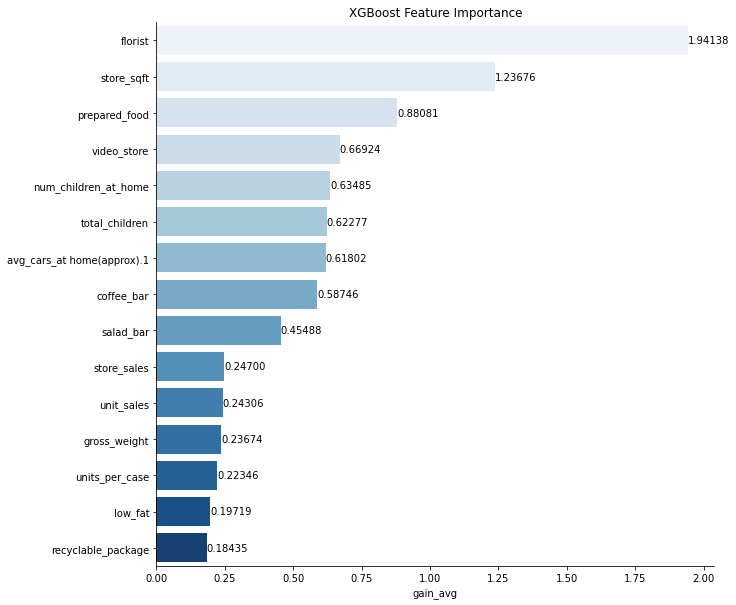

In [399]:
fig = plt.figure(figsize = (10, 10))
axes = sns.barplot(data = feature_importance.sort_values('gain_avg', ascending = False),
                   y=feature_importance.sort_values('gain_avg', ascending = False).index,
                   x = 'gain_avg',
                   orient = 'h',
                  palette='Blues')
axes.set(title = 'XGBoost Feature Importance')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
for i in axes.containers:
    axes.bar_label(i,fmt='%.5f')
plt.show()

The gain barplot shows gaps at thresholds 0.25, 0.5, 0.75, and 1. After using Optuna, it was determined that the optimal threshold to use for feature selection is 0.5.

In [400]:
xgb_feature = feature_importance[feature_importance['gain_avg']>0.5].index.to_list()

In [401]:
xgb_feature

['total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'prepared_food',
 'florist']

In [402]:
xgbfeat_param = {
    'max_depth': 11,
    'learning_rate': 0.3,
    'n_estimators': 500,
    'min_child_weight': 20,
    'alpha': 0.25,
    'lambda': 8.48,
    'colsample_bytree': 0.68,
    'subsample': 0.66,
    'objective': 'reg:squarederror',
     'eval_metric': 'rmse',
     'early_stopping_rounds': 100,
     'n_estimators' : 1000
}


model_results.loc[len(model_results.index)]=model_res_cv(X = X[xgb_feature], 
                                                         y = y,
                                                         model=xgb.XGBRegressor(**xgbfeat_param),
                                                         param = str(xgbfeat_param),
                                                         datasets=0,
                                                         feat_eng='Used only : '+str(xgb_feature)
                                                        )

model_results.loc[len(model_results.index)]=model_res_cv(X = X[xgb_feature], 
                                                         y = y,
                                                         model=xgb.XGBRegressor(**xgbfeat_param),
                                                         param = str(xgbfeat_param),
                                                         datasets=1,
                                                         feat_eng='Used only : '+str(xgb_feature)
                                                        )

In [403]:
model_results

,model,parameters,RMSLE,RMSLE_std,datasets,feat_eng,comments
0,RandomForestRegressor,default,0.307587,0.000837,train,no,Iteration num:[][]
1,RandomForestRegressor,default,0.308496,0.000968,train+original,no,Iteration num:[][]
2,CatBoostRegressor,default,0.298391,0.000407,train,no,"Iteration num:[984, 940, 992, 726, 992][]"
3,CatBoostRegressor,default,0.298159,0.000410,train+original,no,"Iteration num:[984, 991, 948, 973, 996][]"
4,XGBRegressor,default,0.298799,0.000374,train,no,"Iteration num:[][100, 100, 100, 100, 100]"
5,XGBRegressor,default,0.298472,0.000526,train+original,no,"Iteration num:[][100, 100, 100, 100, 100]"
6,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294342,0.000477,train,no,"Iteration num:[177, 217, 249, 190, 241][]"
7,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294156,0.000390,train+original,no,"Iteration num:[230, 248, 212, 236, 196][]"
8,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294010,0.000477,train,"Used only: ['total_children', 'num_children_at...","Iteration num:[1154, 1163, 1071, 953, 1008][]"
9,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.293862,0.000444,train+original,"Used only: ['total_children', 'num_children_at...","Iteration num:[1196, 1090, 1177, 893, 1075][]"


### Adding original dataset for XGBoost model

In [404]:
xgbbest_params = {'max_depth': 11,
                 'learning_rate': 0.13,
                 'n_estimators': 200,
                 'min_child_weight': 2,
                 'alpha': 0.51,
                 'lambda': 1.33,
                 'colsample_bytree': 0.84,
                 'subsample': 0.86,
                 'objective': 'reg:squarederror',
                 'eval_metric': 'rmse',
                 'early_stopping_rounds': 100,
                 'n_estimators' : 1000
                 }

xgb_est = xgb.XGBRegressor(**xgbbest_params)

model_results.loc[len(model_results.index)]=model_res_cv(X[xgb_feature], y,
                                                         model=xgb_est,
                                                         param = str(xgbbest_params),
                                                         datasets=1,
                                                         feat_eng = 'Used only: ' + str(xgb_feature)
                                                        )

In [411]:
x = model_results.loc[len(model_results.index)-1, 'comments'][17:-1].split(", ")
t = round(sum([int(d) for d in x])/len(x)/100)*100

xgbbest_params.pop('early_stopping_rounds')
xgbbest_params.pop('n_estimators')
xgbbest_params['n_estimators'] = t

In [413]:
model_results

,model,parameters,RMSLE,RMSLE_std,datasets,feat_eng,comments
0,RandomForestRegressor,default,0.307587,0.000837,train,no,Iteration num:[][]
1,RandomForestRegressor,default,0.308496,0.000968,train+original,no,Iteration num:[][]
2,CatBoostRegressor,default,0.298391,0.000407,train,no,"Iteration num:[984, 940, 992, 726, 992][]"
3,CatBoostRegressor,default,0.298159,0.000410,train+original,no,"Iteration num:[984, 991, 948, 973, 996][]"
4,XGBRegressor,default,0.298799,0.000374,train,no,"Iteration num:[][100, 100, 100, 100, 100]"
5,XGBRegressor,default,0.298472,0.000526,train+original,no,"Iteration num:[][100, 100, 100, 100, 100]"
6,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294342,0.000477,train,no,"Iteration num:[177, 217, 249, 190, 241][]"
7,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294156,0.000390,train+original,no,"Iteration num:[230, 248, 212, 236, 196][]"
8,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294010,0.000477,train,"Used only: ['total_children', 'num_children_at...","Iteration num:[1154, 1163, 1071, 953, 1008][]"
9,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.293862,0.000444,train+original,"Used only: ['total_children', 'num_children_at...","Iteration num:[1196, 1090, 1177, 893, 1075][]"


### XGBoost prediction vs true values

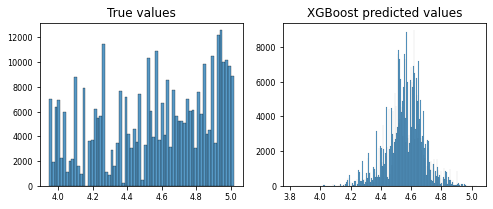

In [414]:
xgb_est = xgb.XGBRegressor(**xgbbest_params)
X_train = pd.concat([X[xgb_feature], X_or[xgb_feature]], axis=0)
y_train = pd.concat([y, y_or], axis=0)
xgb_est.fit(X_train, y_train)
y_xgbpr = xgb_est.predict(X[xgb_feature])

fig, ax = plt.subplots(1, 2, figsize = (8, 3))
sns.histplot(y, ax = ax[0])
sns.histplot(y_xgbpr, ax = ax[1])

# ax[0].set_title(f'{col}', fontweight='bold', fontsize = 14, )
# ax[i][1].set_title(f'{col}', fontweight='bold', fontsize = 14, )
ax[0].tick_params(axis="x", labelsize=8)
ax[1].tick_params(axis="x", labelsize=8)
ax[0].tick_params(axis="y", labelsize=8)
ax[1].tick_params(axis="y", labelsize=8)

ax[0].set(xlabel=None, ylabel=None, title = 'True values')
ax[1].set(xlabel=None, ylabel=None,  title = 'XGBoost predicted values')
plt.show()

# Ensemble of CatBoost and XGBoost

### Tuning of weights

In [415]:
cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=SEED)
rmses_ens = []
rmses_xgb = []
rmses_cb = []
ln_coefs = pd.DataFrame([], columns=['XGB', 'Cat', 'Intersect'])

xgb_est = xgb.XGBRegressor(**xgbbest_params)
cb_est = cb.CatBoostRegressor(**cbbest_params)

ens_models = []
ens_models.append(xgb_est)
ens_models.append(cb_est)

ens_feat = []
ens_feat.append(xgb_feature)
ens_feat.append(cb_feature)


for (ind_train, ind_test) in cv.split(X, y):
    X_train, X_test = X.iloc[ind_train], X.iloc[ind_test]
    y_train, y_test = y.iloc[ind_train], y.iloc[ind_test]

    X_train = pd.concat([X_train, X_or], axis=0)
    y_train = pd.concat([y_train, y_or], axis=0)
    X_train, y_train = shuffle(X_train, y_train)

    y_weight = pd.DataFrame()
    y_pred_test = pd.DataFrame()

    for est, feats in zip(ens_models, ens_feat):
        est.fit(X_train[feats], y_train)
        y_weight[str(est.__class__.__name__)[:3]] = est.predict(X_train[feats])
        y_pred_test[str(est.__class__.__name__)[:3]] = est.predict(X_test[feats])

    ln = linear_model.LinearRegression(fit_intercept = True)
    ln.fit(y_weight, y_train)
    y_pred = ln.predict(y_pred_test)
    ln_coefs.loc[len(ln_coefs), ['XGB', 'Cat']] = ln.coef_
    ln_coefs.loc[len(ln_coefs)-1, ['Intersect']] = ln.intercept_

    rmses_ens.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    rmses_xgb.append(metrics.mean_squared_error(y_test, y_pred_test.iloc[:, 0], squared=False))
    rmses_cb.append(metrics.mean_squared_error(y_test, y_pred_test.iloc[:, 1], squared=False))

0:	learn: 0.3154608	total: 79.3ms	remaining: 2m 22s
1:	learn: 0.3142974	total: 108ms	remaining: 1m 37s
2:	learn: 0.3133123	total: 120ms	remaining: 1m 11s
3:	learn: 0.3125095	total: 131ms	remaining: 58.8s
4:	learn: 0.3118078	total: 142ms	remaining: 51s
5:	learn: 0.3111689	total: 153ms	remaining: 45.9s
6:	learn: 0.3106376	total: 165ms	remaining: 42.2s
7:	learn: 0.3102056	total: 177ms	remaining: 39.6s
8:	learn: 0.3098172	total: 187ms	remaining: 37.2s
9:	learn: 0.3094474	total: 198ms	remaining: 35.4s
10:	learn: 0.3091548	total: 209ms	remaining: 34s
11:	learn: 0.3088829	total: 220ms	remaining: 32.8s
12:	learn: 0.3086524	total: 232ms	remaining: 31.9s
13:	learn: 0.3084396	total: 243ms	remaining: 30.9s
14:	learn: 0.3082300	total: 254ms	remaining: 30.2s
15:	learn: 0.3080559	total: 264ms	remaining: 29.5s
16:	learn: 0.3079117	total: 275ms	remaining: 28.8s
17:	learn: 0.3077721	total: 286ms	remaining: 28.3s
18:	learn: 0.3076123	total: 297ms	remaining: 27.8s
19:	learn: 0.3074898	total: 309ms	remaini

170:	learn: 0.3011880	total: 1.92s	remaining: 18.3s
171:	learn: 0.3011658	total: 1.93s	remaining: 18.3s
172:	learn: 0.3011433	total: 1.94s	remaining: 18.3s
173:	learn: 0.3011201	total: 1.96s	remaining: 18.3s
174:	learn: 0.3010955	total: 1.97s	remaining: 18.3s
175:	learn: 0.3010871	total: 1.98s	remaining: 18.2s
176:	learn: 0.3010711	total: 1.99s	remaining: 18.2s
177:	learn: 0.3010548	total: 2s	remaining: 18.2s
178:	learn: 0.3010320	total: 2.01s	remaining: 18.2s
179:	learn: 0.3010077	total: 2.02s	remaining: 18.2s
180:	learn: 0.3009854	total: 2.03s	remaining: 18.2s
181:	learn: 0.3009775	total: 2.04s	remaining: 18.2s
182:	learn: 0.3009483	total: 2.05s	remaining: 18.1s
183:	learn: 0.3009301	total: 2.06s	remaining: 18.1s
184:	learn: 0.3009072	total: 2.07s	remaining: 18.1s
185:	learn: 0.3008918	total: 2.08s	remaining: 18.1s
186:	learn: 0.3008853	total: 2.09s	remaining: 18.1s
187:	learn: 0.3008672	total: 2.1s	remaining: 18s
188:	learn: 0.3008572	total: 2.11s	remaining: 18s
189:	learn: 0.300833

345:	learn: 0.2990841	total: 3.75s	remaining: 15.8s
346:	learn: 0.2990759	total: 3.76s	remaining: 15.8s
347:	learn: 0.2990729	total: 3.77s	remaining: 15.7s
348:	learn: 0.2990697	total: 3.78s	remaining: 15.7s
349:	learn: 0.2990604	total: 3.79s	remaining: 15.7s
350:	learn: 0.2990506	total: 3.8s	remaining: 15.7s
351:	learn: 0.2990416	total: 3.81s	remaining: 15.7s
352:	learn: 0.2990321	total: 3.82s	remaining: 15.7s
353:	learn: 0.2990277	total: 3.83s	remaining: 15.7s
354:	learn: 0.2990164	total: 3.84s	remaining: 15.6s
355:	learn: 0.2990135	total: 3.85s	remaining: 15.6s
356:	learn: 0.2990038	total: 3.86s	remaining: 15.6s
357:	learn: 0.2989949	total: 3.87s	remaining: 15.6s
358:	learn: 0.2989856	total: 3.88s	remaining: 15.6s
359:	learn: 0.2989709	total: 3.9s	remaining: 15.6s
360:	learn: 0.2989614	total: 3.91s	remaining: 15.6s
361:	learn: 0.2989548	total: 3.92s	remaining: 15.6s
362:	learn: 0.2989474	total: 3.93s	remaining: 15.5s
363:	learn: 0.2989369	total: 3.94s	remaining: 15.5s
364:	learn: 0.

519:	learn: 0.2979968	total: 5.6s	remaining: 13.8s
520:	learn: 0.2979939	total: 5.61s	remaining: 13.8s
521:	learn: 0.2979862	total: 5.62s	remaining: 13.8s
522:	learn: 0.2979807	total: 5.63s	remaining: 13.8s
523:	learn: 0.2979584	total: 5.64s	remaining: 13.7s
524:	learn: 0.2979539	total: 5.65s	remaining: 13.7s
525:	learn: 0.2979515	total: 5.66s	remaining: 13.7s
526:	learn: 0.2979478	total: 5.67s	remaining: 13.7s
527:	learn: 0.2979439	total: 5.69s	remaining: 13.7s
528:	learn: 0.2979375	total: 5.7s	remaining: 13.7s
529:	learn: 0.2979349	total: 5.71s	remaining: 13.7s
530:	learn: 0.2979320	total: 5.72s	remaining: 13.7s
531:	learn: 0.2979284	total: 5.73s	remaining: 13.7s
532:	learn: 0.2979255	total: 5.74s	remaining: 13.6s
533:	learn: 0.2979208	total: 5.75s	remaining: 13.6s
534:	learn: 0.2979187	total: 5.76s	remaining: 13.6s
535:	learn: 0.2979155	total: 5.77s	remaining: 13.6s
536:	learn: 0.2979113	total: 5.78s	remaining: 13.6s
537:	learn: 0.2979072	total: 5.79s	remaining: 13.6s
538:	learn: 0.

687:	learn: 0.2972258	total: 7.42s	remaining: 12s
688:	learn: 0.2972240	total: 7.43s	remaining: 12s
689:	learn: 0.2972173	total: 7.44s	remaining: 12s
690:	learn: 0.2972133	total: 7.45s	remaining: 12s
691:	learn: 0.2972113	total: 7.46s	remaining: 11.9s
692:	learn: 0.2972094	total: 7.47s	remaining: 11.9s
693:	learn: 0.2972077	total: 7.48s	remaining: 11.9s
694:	learn: 0.2972042	total: 7.49s	remaining: 11.9s
695:	learn: 0.2971985	total: 7.5s	remaining: 11.9s
696:	learn: 0.2971958	total: 7.51s	remaining: 11.9s
697:	learn: 0.2971890	total: 7.52s	remaining: 11.9s
698:	learn: 0.2971866	total: 7.53s	remaining: 11.9s
699:	learn: 0.2971806	total: 7.54s	remaining: 11.8s
700:	learn: 0.2971779	total: 7.55s	remaining: 11.8s
701:	learn: 0.2971735	total: 7.56s	remaining: 11.8s
702:	learn: 0.2971697	total: 7.57s	remaining: 11.8s
703:	learn: 0.2971671	total: 7.58s	remaining: 11.8s
704:	learn: 0.2971626	total: 7.59s	remaining: 11.8s
705:	learn: 0.2971595	total: 7.6s	remaining: 11.8s
706:	learn: 0.2971571	

847:	learn: 0.2966279	total: 9.04s	remaining: 10.1s
848:	learn: 0.2966264	total: 9.05s	remaining: 10.1s
849:	learn: 0.2966234	total: 9.05s	remaining: 10.1s
850:	learn: 0.2966211	total: 9.06s	remaining: 10.1s
851:	learn: 0.2966194	total: 9.08s	remaining: 10.1s
852:	learn: 0.2966173	total: 9.09s	remaining: 10.1s
853:	learn: 0.2966145	total: 9.1s	remaining: 10.1s
854:	learn: 0.2966125	total: 9.11s	remaining: 10.1s
855:	learn: 0.2966097	total: 9.12s	remaining: 10.1s
856:	learn: 0.2966068	total: 9.13s	remaining: 10s
857:	learn: 0.2966042	total: 9.14s	remaining: 10s
858:	learn: 0.2966010	total: 9.15s	remaining: 10s
859:	learn: 0.2965922	total: 9.16s	remaining: 10s
860:	learn: 0.2965890	total: 9.17s	remaining: 10s
861:	learn: 0.2965869	total: 9.18s	remaining: 9.99s
862:	learn: 0.2965826	total: 9.19s	remaining: 9.98s
863:	learn: 0.2965801	total: 9.2s	remaining: 9.96s
864:	learn: 0.2965775	total: 9.21s	remaining: 9.95s
865:	learn: 0.2965751	total: 9.22s	remaining: 9.94s
866:	learn: 0.2965722	to

1007:	learn: 0.2961499	total: 10.7s	remaining: 8.37s
1008:	learn: 0.2961414	total: 10.7s	remaining: 8.36s
1009:	learn: 0.2961393	total: 10.7s	remaining: 8.35s
1010:	learn: 0.2961368	total: 10.7s	remaining: 8.34s
1011:	learn: 0.2961342	total: 10.7s	remaining: 8.33s
1012:	learn: 0.2961268	total: 10.7s	remaining: 8.32s
1013:	learn: 0.2961243	total: 10.7s	remaining: 8.31s
1014:	learn: 0.2961222	total: 10.7s	remaining: 8.3s
1015:	learn: 0.2961171	total: 10.7s	remaining: 8.29s
1016:	learn: 0.2961141	total: 10.7s	remaining: 8.27s
1017:	learn: 0.2961109	total: 10.8s	remaining: 8.26s
1018:	learn: 0.2961092	total: 10.8s	remaining: 8.25s
1019:	learn: 0.2961074	total: 10.8s	remaining: 8.24s
1020:	learn: 0.2961058	total: 10.8s	remaining: 8.23s
1021:	learn: 0.2961039	total: 10.8s	remaining: 8.22s
1022:	learn: 0.2961020	total: 10.8s	remaining: 8.21s
1023:	learn: 0.2960998	total: 10.8s	remaining: 8.2s
1024:	learn: 0.2960970	total: 10.8s	remaining: 8.19s
1025:	learn: 0.2960938	total: 10.8s	remaining: 8

1163:	learn: 0.2957314	total: 12.3s	remaining: 6.7s
1164:	learn: 0.2957298	total: 12.3s	remaining: 6.69s
1165:	learn: 0.2957268	total: 12.3s	remaining: 6.68s
1166:	learn: 0.2957246	total: 12.3s	remaining: 6.67s
1167:	learn: 0.2957221	total: 12.3s	remaining: 6.66s
1168:	learn: 0.2957135	total: 12.3s	remaining: 6.65s
1169:	learn: 0.2957120	total: 12.3s	remaining: 6.64s
1170:	learn: 0.2957104	total: 12.3s	remaining: 6.63s
1171:	learn: 0.2957090	total: 12.3s	remaining: 6.62s
1172:	learn: 0.2957067	total: 12.4s	remaining: 6.61s
1173:	learn: 0.2957052	total: 12.4s	remaining: 6.59s
1174:	learn: 0.2957024	total: 12.4s	remaining: 6.58s
1175:	learn: 0.2956995	total: 12.4s	remaining: 6.57s
1176:	learn: 0.2956978	total: 12.4s	remaining: 6.56s
1177:	learn: 0.2956953	total: 12.4s	remaining: 6.55s
1178:	learn: 0.2956933	total: 12.4s	remaining: 6.54s
1179:	learn: 0.2956919	total: 12.4s	remaining: 6.53s
1180:	learn: 0.2956901	total: 12.4s	remaining: 6.52s
1181:	learn: 0.2956884	total: 12.4s	remaining: 

1323:	learn: 0.2953298	total: 13.9s	remaining: 4.99s
1324:	learn: 0.2953263	total: 13.9s	remaining: 4.98s
1325:	learn: 0.2953244	total: 13.9s	remaining: 4.97s
1326:	learn: 0.2953226	total: 13.9s	remaining: 4.96s
1327:	learn: 0.2953208	total: 13.9s	remaining: 4.95s
1328:	learn: 0.2953186	total: 13.9s	remaining: 4.94s
1329:	learn: 0.2953168	total: 13.9s	remaining: 4.93s
1330:	learn: 0.2953143	total: 14s	remaining: 4.92s
1331:	learn: 0.2953124	total: 14s	remaining: 4.91s
1332:	learn: 0.2953109	total: 14s	remaining: 4.9s
1333:	learn: 0.2953091	total: 14s	remaining: 4.89s
1334:	learn: 0.2953075	total: 14s	remaining: 4.88s
1335:	learn: 0.2953057	total: 14s	remaining: 4.87s
1336:	learn: 0.2953029	total: 14s	remaining: 4.86s
1337:	learn: 0.2952972	total: 14s	remaining: 4.84s
1338:	learn: 0.2952957	total: 14s	remaining: 4.83s
1339:	learn: 0.2952934	total: 14.1s	remaining: 4.82s
1340:	learn: 0.2952922	total: 14.1s	remaining: 4.81s
1341:	learn: 0.2952902	total: 14.1s	remaining: 4.8s
1342:	learn: 

1483:	learn: 0.2949720	total: 15.5s	remaining: 3.3s
1484:	learn: 0.2949696	total: 15.5s	remaining: 3.29s
1485:	learn: 0.2949685	total: 15.5s	remaining: 3.28s
1486:	learn: 0.2949656	total: 15.5s	remaining: 3.27s
1487:	learn: 0.2949624	total: 15.6s	remaining: 3.26s
1488:	learn: 0.2949604	total: 15.6s	remaining: 3.25s
1489:	learn: 0.2949593	total: 15.6s	remaining: 3.24s
1490:	learn: 0.2949573	total: 15.6s	remaining: 3.23s
1491:	learn: 0.2949551	total: 15.6s	remaining: 3.22s
1492:	learn: 0.2949536	total: 15.6s	remaining: 3.21s
1493:	learn: 0.2949514	total: 15.6s	remaining: 3.2s
1494:	learn: 0.2949499	total: 15.6s	remaining: 3.19s
1495:	learn: 0.2949476	total: 15.6s	remaining: 3.18s
1496:	learn: 0.2949414	total: 15.6s	remaining: 3.17s
1497:	learn: 0.2949394	total: 15.7s	remaining: 3.16s
1498:	learn: 0.2949371	total: 15.7s	remaining: 3.15s
1499:	learn: 0.2949360	total: 15.7s	remaining: 3.14s
1500:	learn: 0.2949345	total: 15.7s	remaining: 3.13s
1501:	learn: 0.2949330	total: 15.7s	remaining: 3

1639:	learn: 0.2946337	total: 17.1s	remaining: 1.67s
1640:	learn: 0.2946321	total: 17.2s	remaining: 1.66s
1641:	learn: 0.2946307	total: 17.2s	remaining: 1.65s
1642:	learn: 0.2946286	total: 17.2s	remaining: 1.64s
1643:	learn: 0.2946268	total: 17.2s	remaining: 1.63s
1644:	learn: 0.2946248	total: 17.2s	remaining: 1.62s
1645:	learn: 0.2946234	total: 17.2s	remaining: 1.61s
1646:	learn: 0.2946218	total: 17.2s	remaining: 1.6s
1647:	learn: 0.2946203	total: 17.2s	remaining: 1.59s
1648:	learn: 0.2946176	total: 17.2s	remaining: 1.58s
1649:	learn: 0.2946150	total: 17.2s	remaining: 1.57s
1650:	learn: 0.2946134	total: 17.3s	remaining: 1.56s
1651:	learn: 0.2946114	total: 17.3s	remaining: 1.55s
1652:	learn: 0.2946099	total: 17.3s	remaining: 1.54s
1653:	learn: 0.2946072	total: 17.3s	remaining: 1.52s
1654:	learn: 0.2946054	total: 17.3s	remaining: 1.51s
1655:	learn: 0.2946031	total: 17.3s	remaining: 1.5s
1656:	learn: 0.2946016	total: 17.3s	remaining: 1.49s
1657:	learn: 0.2945991	total: 17.3s	remaining: 1

1799:	learn: 0.2943036	total: 18.8s	remaining: 0us
0:	learn: 0.3154402	total: 30.9ms	remaining: 55.5s
1:	learn: 0.3142912	total: 46.4ms	remaining: 41.7s
2:	learn: 0.3133173	total: 59.6ms	remaining: 35.7s
3:	learn: 0.3125294	total: 71.8ms	remaining: 32.2s
4:	learn: 0.3118388	total: 86ms	remaining: 30.9s
5:	learn: 0.3112070	total: 102ms	remaining: 30.5s
6:	learn: 0.3106741	total: 116ms	remaining: 29.6s
7:	learn: 0.3102626	total: 129ms	remaining: 28.9s
8:	learn: 0.3098546	total: 141ms	remaining: 28.1s
9:	learn: 0.3095134	total: 154ms	remaining: 27.7s
10:	learn: 0.3091993	total: 167ms	remaining: 27.2s
11:	learn: 0.3089293	total: 180ms	remaining: 26.8s
12:	learn: 0.3087032	total: 191ms	remaining: 26.3s
13:	learn: 0.3084782	total: 202ms	remaining: 25.8s
14:	learn: 0.3082983	total: 213ms	remaining: 25.4s
15:	learn: 0.3081230	total: 224ms	remaining: 25s
16:	learn: 0.3079862	total: 236ms	remaining: 24.7s
17:	learn: 0.3078376	total: 247ms	remaining: 24.4s
18:	learn: 0.3076886	total: 258ms	remain

173:	learn: 0.3012864	total: 1.86s	remaining: 17.4s
174:	learn: 0.3012639	total: 1.87s	remaining: 17.4s
175:	learn: 0.3012430	total: 1.88s	remaining: 17.4s
176:	learn: 0.3012355	total: 1.89s	remaining: 17.4s
177:	learn: 0.3012157	total: 1.9s	remaining: 17.3s
178:	learn: 0.3011944	total: 1.91s	remaining: 17.3s
179:	learn: 0.3011848	total: 1.92s	remaining: 17.3s
180:	learn: 0.3011659	total: 1.93s	remaining: 17.3s
181:	learn: 0.3011462	total: 1.94s	remaining: 17.3s
182:	learn: 0.3011301	total: 1.95s	remaining: 17.3s
183:	learn: 0.3011112	total: 1.96s	remaining: 17.2s
184:	learn: 0.3010925	total: 1.97s	remaining: 17.2s
185:	learn: 0.3010736	total: 1.98s	remaining: 17.2s
186:	learn: 0.3010579	total: 1.99s	remaining: 17.2s
187:	learn: 0.3010430	total: 2s	remaining: 17.2s
188:	learn: 0.3010289	total: 2.01s	remaining: 17.2s
189:	learn: 0.3010101	total: 2.02s	remaining: 17.2s
190:	learn: 0.3009995	total: 2.04s	remaining: 17.1s
191:	learn: 0.3009793	total: 2.04s	remaining: 17.1s
192:	learn: 0.30

350:	learn: 0.2992026	total: 3.68s	remaining: 15.2s
351:	learn: 0.2991978	total: 3.69s	remaining: 15.2s
352:	learn: 0.2991908	total: 3.7s	remaining: 15.2s
353:	learn: 0.2991863	total: 3.71s	remaining: 15.2s
354:	learn: 0.2991736	total: 3.72s	remaining: 15.2s
355:	learn: 0.2991645	total: 3.73s	remaining: 15.1s
356:	learn: 0.2991586	total: 3.74s	remaining: 15.1s
357:	learn: 0.2991508	total: 3.75s	remaining: 15.1s
358:	learn: 0.2991406	total: 3.76s	remaining: 15.1s
359:	learn: 0.2991364	total: 3.77s	remaining: 15.1s
360:	learn: 0.2991275	total: 3.78s	remaining: 15.1s
361:	learn: 0.2991210	total: 3.79s	remaining: 15.1s
362:	learn: 0.2991161	total: 3.8s	remaining: 15.1s
363:	learn: 0.2991079	total: 3.81s	remaining: 15s
364:	learn: 0.2991035	total: 3.82s	remaining: 15s
365:	learn: 0.2991000	total: 3.83s	remaining: 15s
366:	learn: 0.2990830	total: 3.84s	remaining: 15s
367:	learn: 0.2990771	total: 3.85s	remaining: 15s
368:	learn: 0.2990690	total: 3.86s	remaining: 15s
369:	learn: 0.2990621	tota

510:	learn: 0.2981797	total: 5.31s	remaining: 13.4s
511:	learn: 0.2981753	total: 5.32s	remaining: 13.4s
512:	learn: 0.2981721	total: 5.33s	remaining: 13.4s
513:	learn: 0.2981669	total: 5.34s	remaining: 13.4s
514:	learn: 0.2981612	total: 5.35s	remaining: 13.3s
515:	learn: 0.2981574	total: 5.36s	remaining: 13.3s
516:	learn: 0.2981507	total: 5.37s	remaining: 13.3s
517:	learn: 0.2981426	total: 5.38s	remaining: 13.3s
518:	learn: 0.2981397	total: 5.39s	remaining: 13.3s
519:	learn: 0.2981320	total: 5.4s	remaining: 13.3s
520:	learn: 0.2981273	total: 5.41s	remaining: 13.3s
521:	learn: 0.2981236	total: 5.42s	remaining: 13.3s
522:	learn: 0.2981196	total: 5.43s	remaining: 13.3s
523:	learn: 0.2981102	total: 5.44s	remaining: 13.2s
524:	learn: 0.2981065	total: 5.45s	remaining: 13.2s
525:	learn: 0.2981023	total: 5.46s	remaining: 13.2s
526:	learn: 0.2980973	total: 5.47s	remaining: 13.2s
527:	learn: 0.2980951	total: 5.48s	remaining: 13.2s
528:	learn: 0.2980916	total: 5.49s	remaining: 13.2s
529:	learn: 0

670:	learn: 0.2974871	total: 6.94s	remaining: 11.7s
671:	learn: 0.2974791	total: 6.95s	remaining: 11.7s
672:	learn: 0.2974695	total: 6.96s	remaining: 11.7s
673:	learn: 0.2974666	total: 6.97s	remaining: 11.6s
674:	learn: 0.2974635	total: 6.98s	remaining: 11.6s
675:	learn: 0.2974612	total: 6.99s	remaining: 11.6s
676:	learn: 0.2974575	total: 7s	remaining: 11.6s
677:	learn: 0.2974502	total: 7.01s	remaining: 11.6s
678:	learn: 0.2974423	total: 7.02s	remaining: 11.6s
679:	learn: 0.2974391	total: 7.03s	remaining: 11.6s
680:	learn: 0.2974360	total: 7.04s	remaining: 11.6s
681:	learn: 0.2974333	total: 7.05s	remaining: 11.6s
682:	learn: 0.2974268	total: 7.06s	remaining: 11.5s
683:	learn: 0.2974200	total: 7.07s	remaining: 11.5s
684:	learn: 0.2974167	total: 7.08s	remaining: 11.5s
685:	learn: 0.2974142	total: 7.09s	remaining: 11.5s
686:	learn: 0.2974050	total: 7.1s	remaining: 11.5s
687:	learn: 0.2974020	total: 7.11s	remaining: 11.5s
688:	learn: 0.2973966	total: 7.12s	remaining: 11.5s
689:	learn: 0.29

829:	learn: 0.2968977	total: 8.55s	remaining: 10s
830:	learn: 0.2968947	total: 8.57s	remaining: 9.99s
831:	learn: 0.2968907	total: 8.58s	remaining: 9.98s
832:	learn: 0.2968886	total: 8.59s	remaining: 9.97s
833:	learn: 0.2968861	total: 8.6s	remaining: 9.96s
834:	learn: 0.2968837	total: 8.61s	remaining: 9.95s
835:	learn: 0.2968794	total: 8.62s	remaining: 9.94s
836:	learn: 0.2968753	total: 8.63s	remaining: 9.93s
837:	learn: 0.2968699	total: 8.64s	remaining: 9.91s
838:	learn: 0.2968675	total: 8.65s	remaining: 9.9s
839:	learn: 0.2968658	total: 8.66s	remaining: 9.89s
840:	learn: 0.2968636	total: 8.67s	remaining: 9.88s
841:	learn: 0.2968622	total: 8.68s	remaining: 9.87s
842:	learn: 0.2968594	total: 8.69s	remaining: 9.86s
843:	learn: 0.2968576	total: 8.7s	remaining: 9.85s
844:	learn: 0.2968534	total: 8.71s	remaining: 9.84s
845:	learn: 0.2968514	total: 8.72s	remaining: 9.83s
846:	learn: 0.2968456	total: 8.73s	remaining: 9.82s
847:	learn: 0.2968427	total: 8.74s	remaining: 9.81s
848:	learn: 0.296

1001:	learn: 0.2963195	total: 10.4s	remaining: 8.27s
1002:	learn: 0.2963127	total: 10.4s	remaining: 8.26s
1003:	learn: 0.2963102	total: 10.4s	remaining: 8.25s
1004:	learn: 0.2963087	total: 10.4s	remaining: 8.24s
1005:	learn: 0.2963064	total: 10.4s	remaining: 8.23s
1006:	learn: 0.2963042	total: 10.4s	remaining: 8.22s
1007:	learn: 0.2963023	total: 10.4s	remaining: 8.21s
1008:	learn: 0.2963008	total: 10.5s	remaining: 8.2s
1009:	learn: 0.2962991	total: 10.5s	remaining: 8.19s
1010:	learn: 0.2962968	total: 10.5s	remaining: 8.19s
1011:	learn: 0.2962923	total: 10.5s	remaining: 8.18s
1012:	learn: 0.2962890	total: 10.5s	remaining: 8.17s
1013:	learn: 0.2962869	total: 10.5s	remaining: 8.16s
1014:	learn: 0.2962848	total: 10.5s	remaining: 8.15s
1015:	learn: 0.2962828	total: 10.5s	remaining: 8.14s
1016:	learn: 0.2962798	total: 10.6s	remaining: 8.13s
1017:	learn: 0.2962750	total: 10.6s	remaining: 8.12s
1018:	learn: 0.2962704	total: 10.6s	remaining: 8.11s
1019:	learn: 0.2962639	total: 10.6s	remaining: 

1170:	learn: 0.2958421	total: 12.2s	remaining: 6.56s
1171:	learn: 0.2958317	total: 12.2s	remaining: 6.55s
1172:	learn: 0.2958258	total: 12.2s	remaining: 6.54s
1173:	learn: 0.2958234	total: 12.2s	remaining: 6.53s
1174:	learn: 0.2958215	total: 12.3s	remaining: 6.52s
1175:	learn: 0.2958185	total: 12.3s	remaining: 6.51s
1176:	learn: 0.2958160	total: 12.3s	remaining: 6.5s
1177:	learn: 0.2958128	total: 12.3s	remaining: 6.49s
1178:	learn: 0.2958080	total: 12.3s	remaining: 6.47s
1179:	learn: 0.2958056	total: 12.3s	remaining: 6.46s
1180:	learn: 0.2958036	total: 12.3s	remaining: 6.45s
1181:	learn: 0.2957981	total: 12.3s	remaining: 6.44s
1182:	learn: 0.2957962	total: 12.3s	remaining: 6.43s
1183:	learn: 0.2957945	total: 12.3s	remaining: 6.42s
1184:	learn: 0.2957910	total: 12.4s	remaining: 6.41s
1185:	learn: 0.2957892	total: 12.4s	remaining: 6.4s
1186:	learn: 0.2957878	total: 12.4s	remaining: 6.39s
1187:	learn: 0.2957859	total: 12.4s	remaining: 6.38s
1188:	learn: 0.2957831	total: 12.4s	remaining: 6

1330:	learn: 0.2954178	total: 13.8s	remaining: 4.88s
1331:	learn: 0.2954159	total: 13.9s	remaining: 4.87s
1332:	learn: 0.2954140	total: 13.9s	remaining: 4.86s
1333:	learn: 0.2954126	total: 13.9s	remaining: 4.85s
1334:	learn: 0.2954081	total: 13.9s	remaining: 4.83s
1335:	learn: 0.2954068	total: 13.9s	remaining: 4.83s
1336:	learn: 0.2954051	total: 13.9s	remaining: 4.81s
1337:	learn: 0.2954032	total: 13.9s	remaining: 4.8s
1338:	learn: 0.2954016	total: 13.9s	remaining: 4.79s
1339:	learn: 0.2953998	total: 13.9s	remaining: 4.78s
1340:	learn: 0.2953973	total: 13.9s	remaining: 4.77s
1341:	learn: 0.2953946	total: 14s	remaining: 4.76s
1342:	learn: 0.2953925	total: 14s	remaining: 4.75s
1343:	learn: 0.2953905	total: 14s	remaining: 4.74s
1344:	learn: 0.2953886	total: 14s	remaining: 4.73s
1345:	learn: 0.2953864	total: 14s	remaining: 4.72s
1346:	learn: 0.2953851	total: 14s	remaining: 4.71s
1347:	learn: 0.2953838	total: 14s	remaining: 4.7s
1348:	learn: 0.2953819	total: 14s	remaining: 4.69s
1349:	learn

1490:	learn: 0.2950836	total: 15.5s	remaining: 3.21s
1491:	learn: 0.2950822	total: 15.5s	remaining: 3.19s
1492:	learn: 0.2950805	total: 15.5s	remaining: 3.19s
1493:	learn: 0.2950782	total: 15.5s	remaining: 3.17s
1494:	learn: 0.2950769	total: 15.5s	remaining: 3.16s
1495:	learn: 0.2950744	total: 15.5s	remaining: 3.15s
1496:	learn: 0.2950728	total: 15.5s	remaining: 3.14s
1497:	learn: 0.2950702	total: 15.5s	remaining: 3.13s
1498:	learn: 0.2950687	total: 15.6s	remaining: 3.12s
1499:	learn: 0.2950671	total: 15.6s	remaining: 3.11s
1500:	learn: 0.2950654	total: 15.6s	remaining: 3.1s
1501:	learn: 0.2950628	total: 15.6s	remaining: 3.09s
1502:	learn: 0.2950611	total: 15.6s	remaining: 3.08s
1503:	learn: 0.2950599	total: 15.6s	remaining: 3.07s
1504:	learn: 0.2950572	total: 15.6s	remaining: 3.06s
1505:	learn: 0.2950549	total: 15.6s	remaining: 3.05s
1506:	learn: 0.2950518	total: 15.6s	remaining: 3.04s
1507:	learn: 0.2950502	total: 15.6s	remaining: 3.03s
1508:	learn: 0.2950489	total: 15.7s	remaining: 

1650:	learn: 0.2947397	total: 17.1s	remaining: 1.54s
1651:	learn: 0.2947354	total: 17.1s	remaining: 1.53s
1652:	learn: 0.2947332	total: 17.1s	remaining: 1.52s
1653:	learn: 0.2947315	total: 17.1s	remaining: 1.51s
1654:	learn: 0.2947293	total: 17.1s	remaining: 1.5s
1655:	learn: 0.2947271	total: 17.1s	remaining: 1.49s
1656:	learn: 0.2947251	total: 17.1s	remaining: 1.48s
1657:	learn: 0.2947234	total: 17.2s	remaining: 1.47s
1658:	learn: 0.2947212	total: 17.2s	remaining: 1.46s
1659:	learn: 0.2947198	total: 17.2s	remaining: 1.45s
1660:	learn: 0.2947178	total: 17.2s	remaining: 1.44s
1661:	learn: 0.2947155	total: 17.2s	remaining: 1.43s
1662:	learn: 0.2947133	total: 17.2s	remaining: 1.42s
1663:	learn: 0.2947122	total: 17.2s	remaining: 1.41s
1664:	learn: 0.2947101	total: 17.2s	remaining: 1.4s
1665:	learn: 0.2947086	total: 17.2s	remaining: 1.39s
1666:	learn: 0.2947066	total: 17.2s	remaining: 1.38s
1667:	learn: 0.2947055	total: 17.3s	remaining: 1.36s
1668:	learn: 0.2947038	total: 17.3s	remaining: 1

17:	learn: 0.3079882	total: 228ms	remaining: 22.5s
18:	learn: 0.3078768	total: 240ms	remaining: 22.5s
19:	learn: 0.3077437	total: 251ms	remaining: 22.4s
20:	learn: 0.3076194	total: 263ms	remaining: 22.3s
21:	learn: 0.3074923	total: 274ms	remaining: 22.1s
22:	learn: 0.3073619	total: 285ms	remaining: 22s
23:	learn: 0.3072705	total: 296ms	remaining: 21.9s
24:	learn: 0.3071726	total: 307ms	remaining: 21.8s
25:	learn: 0.3070960	total: 319ms	remaining: 21.7s
26:	learn: 0.3069794	total: 329ms	remaining: 21.6s
27:	learn: 0.3069206	total: 340ms	remaining: 21.5s
28:	learn: 0.3068306	total: 352ms	remaining: 21.5s
29:	learn: 0.3067436	total: 362ms	remaining: 21.3s
30:	learn: 0.3066731	total: 373ms	remaining: 21.3s
31:	learn: 0.3065811	total: 383ms	remaining: 21.2s
32:	learn: 0.3065115	total: 394ms	remaining: 21.1s
33:	learn: 0.3064500	total: 405ms	remaining: 21s
34:	learn: 0.3063769	total: 415ms	remaining: 20.9s
35:	learn: 0.3062566	total: 426ms	remaining: 20.9s
36:	learn: 0.3061818	total: 436ms	r

187:	learn: 0.3010228	total: 2.03s	remaining: 17.4s
188:	learn: 0.3010154	total: 2.04s	remaining: 17.4s
189:	learn: 0.3010059	total: 2.05s	remaining: 17.4s
190:	learn: 0.3009924	total: 2.06s	remaining: 17.4s
191:	learn: 0.3009839	total: 2.07s	remaining: 17.3s
192:	learn: 0.3009767	total: 2.08s	remaining: 17.3s
193:	learn: 0.3009537	total: 2.09s	remaining: 17.3s
194:	learn: 0.3009328	total: 2.1s	remaining: 17.3s
195:	learn: 0.3009183	total: 2.11s	remaining: 17.3s
196:	learn: 0.3009062	total: 2.12s	remaining: 17.3s
197:	learn: 0.3008830	total: 2.13s	remaining: 17.3s
198:	learn: 0.3008784	total: 2.14s	remaining: 17.2s
199:	learn: 0.3008558	total: 2.15s	remaining: 17.2s
200:	learn: 0.3008383	total: 2.16s	remaining: 17.2s
201:	learn: 0.3008251	total: 2.17s	remaining: 17.2s
202:	learn: 0.3008137	total: 2.18s	remaining: 17.2s
203:	learn: 0.3007974	total: 2.19s	remaining: 17.2s
204:	learn: 0.3007940	total: 2.21s	remaining: 17.2s
205:	learn: 0.3007729	total: 2.22s	remaining: 17.2s
206:	learn: 0

359:	learn: 0.2991850	total: 3.83s	remaining: 15.3s
360:	learn: 0.2991743	total: 3.84s	remaining: 15.3s
361:	learn: 0.2991642	total: 3.85s	remaining: 15.3s
362:	learn: 0.2991590	total: 3.86s	remaining: 15.3s
363:	learn: 0.2991527	total: 3.87s	remaining: 15.3s
364:	learn: 0.2991425	total: 3.88s	remaining: 15.3s
365:	learn: 0.2991365	total: 3.89s	remaining: 15.2s
366:	learn: 0.2991287	total: 3.9s	remaining: 15.2s
367:	learn: 0.2991218	total: 3.91s	remaining: 15.2s
368:	learn: 0.2991173	total: 3.92s	remaining: 15.2s
369:	learn: 0.2991044	total: 3.93s	remaining: 15.2s
370:	learn: 0.2990992	total: 3.94s	remaining: 15.2s
371:	learn: 0.2990917	total: 3.95s	remaining: 15.2s
372:	learn: 0.2990885	total: 3.96s	remaining: 15.2s
373:	learn: 0.2990853	total: 3.97s	remaining: 15.1s
374:	learn: 0.2990807	total: 3.98s	remaining: 15.1s
375:	learn: 0.2990758	total: 3.99s	remaining: 15.1s
376:	learn: 0.2990700	total: 4.01s	remaining: 15.1s
377:	learn: 0.2990659	total: 4.02s	remaining: 15.1s
378:	learn: 0

534:	learn: 0.2981143	total: 5.66s	remaining: 13.4s
535:	learn: 0.2981108	total: 5.68s	remaining: 13.4s
536:	learn: 0.2981079	total: 5.69s	remaining: 13.4s
537:	learn: 0.2981041	total: 5.7s	remaining: 13.4s
538:	learn: 0.2980981	total: 5.71s	remaining: 13.4s
539:	learn: 0.2980951	total: 5.72s	remaining: 13.3s
540:	learn: 0.2980928	total: 5.73s	remaining: 13.3s
541:	learn: 0.2980886	total: 5.74s	remaining: 13.3s
542:	learn: 0.2980805	total: 5.75s	remaining: 13.3s
543:	learn: 0.2980776	total: 5.76s	remaining: 13.3s
544:	learn: 0.2980726	total: 5.77s	remaining: 13.3s
545:	learn: 0.2980697	total: 5.78s	remaining: 13.3s
546:	learn: 0.2980645	total: 5.79s	remaining: 13.3s
547:	learn: 0.2980602	total: 5.8s	remaining: 13.3s
548:	learn: 0.2980561	total: 5.81s	remaining: 13.2s
549:	learn: 0.2980539	total: 5.82s	remaining: 13.2s
550:	learn: 0.2980514	total: 5.83s	remaining: 13.2s
551:	learn: 0.2980492	total: 5.84s	remaining: 13.2s
552:	learn: 0.2980440	total: 5.85s	remaining: 13.2s
553:	learn: 0.

709:	learn: 0.2973517	total: 7.48s	remaining: 11.5s
710:	learn: 0.2973487	total: 7.49s	remaining: 11.5s
711:	learn: 0.2973452	total: 7.51s	remaining: 11.5s
712:	learn: 0.2973402	total: 7.52s	remaining: 11.5s
713:	learn: 0.2973355	total: 7.53s	remaining: 11.4s
714:	learn: 0.2973321	total: 7.54s	remaining: 11.4s
715:	learn: 0.2973284	total: 7.55s	remaining: 11.4s
716:	learn: 0.2973226	total: 7.56s	remaining: 11.4s
717:	learn: 0.2973157	total: 7.57s	remaining: 11.4s
718:	learn: 0.2973120	total: 7.58s	remaining: 11.4s
719:	learn: 0.2973092	total: 7.59s	remaining: 11.4s
720:	learn: 0.2973064	total: 7.6s	remaining: 11.4s
721:	learn: 0.2973032	total: 7.61s	remaining: 11.4s
722:	learn: 0.2973000	total: 7.62s	remaining: 11.4s
723:	learn: 0.2972971	total: 7.63s	remaining: 11.3s
724:	learn: 0.2972946	total: 7.64s	remaining: 11.3s
725:	learn: 0.2972908	total: 7.65s	remaining: 11.3s
726:	learn: 0.2972812	total: 7.66s	remaining: 11.3s
727:	learn: 0.2972781	total: 7.67s	remaining: 11.3s
728:	learn: 0

886:	learn: 0.2966894	total: 9.32s	remaining: 9.6s
887:	learn: 0.2966876	total: 9.33s	remaining: 9.59s
888:	learn: 0.2966850	total: 9.35s	remaining: 9.58s
889:	learn: 0.2966840	total: 9.36s	remaining: 9.57s
890:	learn: 0.2966811	total: 9.37s	remaining: 9.55s
891:	learn: 0.2966785	total: 9.38s	remaining: 9.54s
892:	learn: 0.2966749	total: 9.39s	remaining: 9.53s
893:	learn: 0.2966722	total: 9.4s	remaining: 9.52s
894:	learn: 0.2966701	total: 9.41s	remaining: 9.51s
895:	learn: 0.2966625	total: 9.42s	remaining: 9.5s
896:	learn: 0.2966602	total: 9.43s	remaining: 9.49s
897:	learn: 0.2966575	total: 9.44s	remaining: 9.48s
898:	learn: 0.2966550	total: 9.45s	remaining: 9.47s
899:	learn: 0.2966517	total: 9.46s	remaining: 9.46s
900:	learn: 0.2966499	total: 9.47s	remaining: 9.45s
901:	learn: 0.2966477	total: 9.48s	remaining: 9.44s
902:	learn: 0.2966449	total: 9.49s	remaining: 9.43s
903:	learn: 0.2966381	total: 9.5s	remaining: 9.41s
904:	learn: 0.2966358	total: 9.51s	remaining: 9.4s
905:	learn: 0.296

1044:	learn: 0.2962165	total: 10.9s	remaining: 7.91s
1045:	learn: 0.2962140	total: 11s	remaining: 7.9s
1046:	learn: 0.2962099	total: 11s	remaining: 7.89s
1047:	learn: 0.2962072	total: 11s	remaining: 7.88s
1048:	learn: 0.2962053	total: 11s	remaining: 7.87s
1049:	learn: 0.2962036	total: 11s	remaining: 7.86s
1050:	learn: 0.2961981	total: 11s	remaining: 7.85s
1051:	learn: 0.2961939	total: 11s	remaining: 7.84s
1052:	learn: 0.2961831	total: 11s	remaining: 7.83s
1053:	learn: 0.2961800	total: 11s	remaining: 7.82s
1054:	learn: 0.2961768	total: 11.1s	remaining: 7.8s
1055:	learn: 0.2961745	total: 11.1s	remaining: 7.79s
1056:	learn: 0.2961731	total: 11.1s	remaining: 7.78s
1057:	learn: 0.2961710	total: 11.1s	remaining: 7.77s
1058:	learn: 0.2961688	total: 11.1s	remaining: 7.76s
1059:	learn: 0.2961612	total: 11.1s	remaining: 7.75s
1060:	learn: 0.2961587	total: 11.1s	remaining: 7.74s
1061:	learn: 0.2961564	total: 11.1s	remaining: 7.73s
1062:	learn: 0.2961534	total: 11.1s	remaining: 7.72s
1063:	learn: 

1203:	learn: 0.2958064	total: 12.6s	remaining: 6.24s
1204:	learn: 0.2958046	total: 12.6s	remaining: 6.23s
1205:	learn: 0.2958023	total: 12.6s	remaining: 6.22s
1206:	learn: 0.2958007	total: 12.6s	remaining: 6.21s
1207:	learn: 0.2957995	total: 12.6s	remaining: 6.2s
1208:	learn: 0.2957957	total: 12.7s	remaining: 6.18s
1209:	learn: 0.2957925	total: 12.7s	remaining: 6.17s
1210:	learn: 0.2957812	total: 12.7s	remaining: 6.16s
1211:	learn: 0.2957798	total: 12.7s	remaining: 6.15s
1212:	learn: 0.2957780	total: 12.7s	remaining: 6.14s
1213:	learn: 0.2957764	total: 12.7s	remaining: 6.13s
1214:	learn: 0.2957744	total: 12.7s	remaining: 6.12s
1215:	learn: 0.2957730	total: 12.7s	remaining: 6.11s
1216:	learn: 0.2957711	total: 12.7s	remaining: 6.1s
1217:	learn: 0.2957692	total: 12.7s	remaining: 6.09s
1218:	learn: 0.2957673	total: 12.8s	remaining: 6.08s
1219:	learn: 0.2957663	total: 12.8s	remaining: 6.07s
1220:	learn: 0.2957643	total: 12.8s	remaining: 6.06s
1221:	learn: 0.2957619	total: 12.8s	remaining: 6

1375:	learn: 0.2953833	total: 14.4s	remaining: 4.45s
1376:	learn: 0.2953790	total: 14.5s	remaining: 4.44s
1377:	learn: 0.2953775	total: 14.5s	remaining: 4.43s
1378:	learn: 0.2953759	total: 14.5s	remaining: 4.42s
1379:	learn: 0.2953744	total: 14.5s	remaining: 4.41s
1380:	learn: 0.2953724	total: 14.5s	remaining: 4.4s
1381:	learn: 0.2953710	total: 14.5s	remaining: 4.39s
1382:	learn: 0.2953687	total: 14.5s	remaining: 4.38s
1383:	learn: 0.2953666	total: 14.5s	remaining: 4.37s
1384:	learn: 0.2953650	total: 14.5s	remaining: 4.36s
1385:	learn: 0.2953612	total: 14.6s	remaining: 4.35s
1386:	learn: 0.2953600	total: 14.6s	remaining: 4.34s
1387:	learn: 0.2953576	total: 14.6s	remaining: 4.33s
1388:	learn: 0.2953541	total: 14.6s	remaining: 4.32s
1389:	learn: 0.2953523	total: 14.6s	remaining: 4.31s
1390:	learn: 0.2953505	total: 14.6s	remaining: 4.3s
1391:	learn: 0.2953460	total: 14.6s	remaining: 4.29s
1392:	learn: 0.2953444	total: 14.6s	remaining: 4.28s
1393:	learn: 0.2953417	total: 14.6s	remaining: 4

1535:	learn: 0.2950046	total: 16.3s	remaining: 2.8s
1536:	learn: 0.2950027	total: 16.3s	remaining: 2.79s
1537:	learn: 0.2949993	total: 16.3s	remaining: 2.77s
1538:	learn: 0.2949985	total: 16.3s	remaining: 2.76s
1539:	learn: 0.2949965	total: 16.3s	remaining: 2.75s
1540:	learn: 0.2949950	total: 16.3s	remaining: 2.74s
1541:	learn: 0.2949929	total: 16.3s	remaining: 2.73s
1542:	learn: 0.2949899	total: 16.3s	remaining: 2.72s
1543:	learn: 0.2949882	total: 16.4s	remaining: 2.71s
1544:	learn: 0.2949854	total: 16.4s	remaining: 2.7s
1545:	learn: 0.2949821	total: 16.4s	remaining: 2.69s
1546:	learn: 0.2949801	total: 16.4s	remaining: 2.68s
1547:	learn: 0.2949782	total: 16.4s	remaining: 2.67s
1548:	learn: 0.2949769	total: 16.4s	remaining: 2.66s
1549:	learn: 0.2949759	total: 16.4s	remaining: 2.65s
1550:	learn: 0.2949744	total: 16.4s	remaining: 2.64s
1551:	learn: 0.2949731	total: 16.4s	remaining: 2.63s
1552:	learn: 0.2949714	total: 16.4s	remaining: 2.62s
1553:	learn: 0.2949688	total: 16.5s	remaining: 2

1709:	learn: 0.2946369	total: 18.1s	remaining: 952ms
1710:	learn: 0.2946353	total: 18.1s	remaining: 941ms
1711:	learn: 0.2946330	total: 18.1s	remaining: 931ms
1712:	learn: 0.2946310	total: 18.1s	remaining: 920ms
1713:	learn: 0.2946298	total: 18.1s	remaining: 910ms
1714:	learn: 0.2946275	total: 18.1s	remaining: 899ms
1715:	learn: 0.2946249	total: 18.1s	remaining: 888ms
1716:	learn: 0.2946236	total: 18.2s	remaining: 878ms
1717:	learn: 0.2946221	total: 18.2s	remaining: 867ms
1718:	learn: 0.2946203	total: 18.2s	remaining: 857ms
1719:	learn: 0.2946181	total: 18.2s	remaining: 846ms
1720:	learn: 0.2946134	total: 18.2s	remaining: 835ms
1721:	learn: 0.2946078	total: 18.2s	remaining: 825ms
1722:	learn: 0.2946027	total: 18.2s	remaining: 814ms
1723:	learn: 0.2945999	total: 18.2s	remaining: 804ms
1724:	learn: 0.2945974	total: 18.2s	remaining: 793ms
1725:	learn: 0.2945954	total: 18.3s	remaining: 783ms
1726:	learn: 0.2945936	total: 18.3s	remaining: 772ms
1727:	learn: 0.2945911	total: 18.3s	remaining:

73:	learn: 0.3038600	total: 829ms	remaining: 19.3s
74:	learn: 0.3038209	total: 841ms	remaining: 19.4s
75:	learn: 0.3037731	total: 852ms	remaining: 19.3s
76:	learn: 0.3037262	total: 862ms	remaining: 19.3s
77:	learn: 0.3037171	total: 873ms	remaining: 19.3s
78:	learn: 0.3036657	total: 884ms	remaining: 19.3s
79:	learn: 0.3036356	total: 895ms	remaining: 19.2s
80:	learn: 0.3035772	total: 905ms	remaining: 19.2s
81:	learn: 0.3035186	total: 915ms	remaining: 19.2s
82:	learn: 0.3034925	total: 925ms	remaining: 19.1s
83:	learn: 0.3034580	total: 936ms	remaining: 19.1s
84:	learn: 0.3034315	total: 946ms	remaining: 19.1s
85:	learn: 0.3033860	total: 956ms	remaining: 19.1s
86:	learn: 0.3033528	total: 968ms	remaining: 19.1s
87:	learn: 0.3033208	total: 979ms	remaining: 19s
88:	learn: 0.3032869	total: 990ms	remaining: 19s
89:	learn: 0.3032573	total: 1000ms	remaining: 19s
90:	learn: 0.3032262	total: 1.01s	remaining: 19s
91:	learn: 0.3031972	total: 1.02s	remaining: 19s
92:	learn: 0.3031592	total: 1.03s	remain

239:	learn: 0.3003516	total: 2.66s	remaining: 17.3s
240:	learn: 0.3003389	total: 2.68s	remaining: 17.3s
241:	learn: 0.3003313	total: 2.69s	remaining: 17.3s
242:	learn: 0.3003168	total: 2.7s	remaining: 17.3s
243:	learn: 0.3002947	total: 2.71s	remaining: 17.3s
244:	learn: 0.3002731	total: 2.73s	remaining: 17.3s
245:	learn: 0.3002655	total: 2.74s	remaining: 17.3s
246:	learn: 0.3002435	total: 2.75s	remaining: 17.3s
247:	learn: 0.3002275	total: 2.76s	remaining: 17.3s
248:	learn: 0.3002171	total: 2.77s	remaining: 17.3s
249:	learn: 0.3002063	total: 2.79s	remaining: 17.3s
250:	learn: 0.3001911	total: 2.8s	remaining: 17.3s
251:	learn: 0.3001753	total: 2.81s	remaining: 17.3s
252:	learn: 0.3001700	total: 2.82s	remaining: 17.2s
253:	learn: 0.3001533	total: 2.83s	remaining: 17.2s
254:	learn: 0.3001425	total: 2.84s	remaining: 17.2s
255:	learn: 0.3001367	total: 2.85s	remaining: 17.2s
256:	learn: 0.3001218	total: 2.87s	remaining: 17.2s
257:	learn: 0.3001161	total: 2.88s	remaining: 17.2s
258:	learn: 0.

412:	learn: 0.2987047	total: 4.69s	remaining: 15.7s
413:	learn: 0.2987007	total: 4.7s	remaining: 15.7s
414:	learn: 0.2986954	total: 4.71s	remaining: 15.7s
415:	learn: 0.2986918	total: 4.72s	remaining: 15.7s
416:	learn: 0.2986839	total: 4.73s	remaining: 15.7s
417:	learn: 0.2986800	total: 4.74s	remaining: 15.7s
418:	learn: 0.2986668	total: 4.75s	remaining: 15.7s
419:	learn: 0.2986639	total: 4.76s	remaining: 15.7s
420:	learn: 0.2986602	total: 4.77s	remaining: 15.6s
421:	learn: 0.2986536	total: 4.78s	remaining: 15.6s
422:	learn: 0.2986495	total: 4.79s	remaining: 15.6s
423:	learn: 0.2986452	total: 4.8s	remaining: 15.6s
424:	learn: 0.2986418	total: 4.82s	remaining: 15.6s
425:	learn: 0.2986264	total: 4.83s	remaining: 15.6s
426:	learn: 0.2986214	total: 4.84s	remaining: 15.6s
427:	learn: 0.2986161	total: 4.85s	remaining: 15.5s
428:	learn: 0.2986049	total: 4.86s	remaining: 15.5s
429:	learn: 0.2986024	total: 4.87s	remaining: 15.5s
430:	learn: 0.2985894	total: 4.88s	remaining: 15.5s
431:	learn: 0.

586:	learn: 0.2977522	total: 6.51s	remaining: 13.4s
587:	learn: 0.2977498	total: 6.52s	remaining: 13.4s
588:	learn: 0.2977469	total: 6.53s	remaining: 13.4s
589:	learn: 0.2977449	total: 6.54s	remaining: 13.4s
590:	learn: 0.2977427	total: 6.55s	remaining: 13.4s
591:	learn: 0.2977381	total: 6.56s	remaining: 13.4s
592:	learn: 0.2977337	total: 6.57s	remaining: 13.4s
593:	learn: 0.2977280	total: 6.58s	remaining: 13.4s
594:	learn: 0.2977234	total: 6.59s	remaining: 13.4s
595:	learn: 0.2977182	total: 6.6s	remaining: 13.3s
596:	learn: 0.2977133	total: 6.61s	remaining: 13.3s
597:	learn: 0.2977081	total: 6.62s	remaining: 13.3s
598:	learn: 0.2977039	total: 6.63s	remaining: 13.3s
599:	learn: 0.2977012	total: 6.64s	remaining: 13.3s
600:	learn: 0.2976985	total: 6.66s	remaining: 13.3s
601:	learn: 0.2976851	total: 6.67s	remaining: 13.3s
602:	learn: 0.2976808	total: 6.68s	remaining: 13.3s
603:	learn: 0.2976710	total: 6.69s	remaining: 13.2s
604:	learn: 0.2976692	total: 6.7s	remaining: 13.2s
605:	learn: 0.

756:	learn: 0.2970380	total: 8.32s	remaining: 11.5s
757:	learn: 0.2970349	total: 8.33s	remaining: 11.5s
758:	learn: 0.2970329	total: 8.34s	remaining: 11.4s
759:	learn: 0.2970304	total: 8.35s	remaining: 11.4s
760:	learn: 0.2970240	total: 8.36s	remaining: 11.4s
761:	learn: 0.2970212	total: 8.37s	remaining: 11.4s
762:	learn: 0.2970180	total: 8.38s	remaining: 11.4s
763:	learn: 0.2970161	total: 8.39s	remaining: 11.4s
764:	learn: 0.2970127	total: 8.41s	remaining: 11.4s
765:	learn: 0.2970100	total: 8.42s	remaining: 11.4s
766:	learn: 0.2970070	total: 8.43s	remaining: 11.3s
767:	learn: 0.2970039	total: 8.44s	remaining: 11.3s
768:	learn: 0.2970020	total: 8.45s	remaining: 11.3s
769:	learn: 0.2969980	total: 8.46s	remaining: 11.3s
770:	learn: 0.2969950	total: 8.47s	remaining: 11.3s
771:	learn: 0.2969916	total: 8.48s	remaining: 11.3s
772:	learn: 0.2969894	total: 8.49s	remaining: 11.3s
773:	learn: 0.2969869	total: 8.5s	remaining: 11.3s
774:	learn: 0.2969816	total: 8.51s	remaining: 11.3s
775:	learn: 0

930:	learn: 0.2964248	total: 10.2s	remaining: 9.47s
931:	learn: 0.2964190	total: 10.2s	remaining: 9.46s
932:	learn: 0.2964128	total: 10.2s	remaining: 9.45s
933:	learn: 0.2964075	total: 10.2s	remaining: 9.44s
934:	learn: 0.2964056	total: 10.2s	remaining: 9.43s
935:	learn: 0.2964027	total: 10.2s	remaining: 9.42s
936:	learn: 0.2964002	total: 10.2s	remaining: 9.41s
937:	learn: 0.2963972	total: 10.2s	remaining: 9.4s
938:	learn: 0.2963954	total: 10.2s	remaining: 9.39s
939:	learn: 0.2963875	total: 10.2s	remaining: 9.38s
940:	learn: 0.2963822	total: 10.3s	remaining: 9.36s
941:	learn: 0.2963799	total: 10.3s	remaining: 9.35s
942:	learn: 0.2963772	total: 10.3s	remaining: 9.34s
943:	learn: 0.2963745	total: 10.3s	remaining: 9.33s
944:	learn: 0.2963725	total: 10.3s	remaining: 9.32s
945:	learn: 0.2963705	total: 10.3s	remaining: 9.31s
946:	learn: 0.2963683	total: 10.3s	remaining: 9.29s
947:	learn: 0.2963658	total: 10.3s	remaining: 9.28s
948:	learn: 0.2963643	total: 10.3s	remaining: 9.27s
949:	learn: 0

1102:	learn: 0.2959142	total: 12s	remaining: 7.56s
1103:	learn: 0.2959117	total: 12s	remaining: 7.55s
1104:	learn: 0.2959091	total: 12s	remaining: 7.54s
1105:	learn: 0.2959062	total: 12s	remaining: 7.52s
1106:	learn: 0.2959031	total: 12s	remaining: 7.51s
1107:	learn: 0.2959004	total: 12s	remaining: 7.5s
1108:	learn: 0.2958983	total: 12s	remaining: 7.49s
1109:	learn: 0.2958958	total: 12s	remaining: 7.48s
1110:	learn: 0.2958902	total: 12s	remaining: 7.47s
1111:	learn: 0.2958883	total: 12.1s	remaining: 7.46s
1112:	learn: 0.2958853	total: 12.1s	remaining: 7.45s
1113:	learn: 0.2958824	total: 12.1s	remaining: 7.43s
1114:	learn: 0.2958790	total: 12.1s	remaining: 7.42s
1115:	learn: 0.2958737	total: 12.1s	remaining: 7.41s
1116:	learn: 0.2958717	total: 12.1s	remaining: 7.4s
1117:	learn: 0.2958697	total: 12.1s	remaining: 7.39s
1118:	learn: 0.2958665	total: 12.1s	remaining: 7.38s
1119:	learn: 0.2958643	total: 12.1s	remaining: 7.37s
1120:	learn: 0.2958624	total: 12.1s	remaining: 7.36s
1121:	learn: 

1273:	learn: 0.2953935	total: 13.8s	remaining: 5.68s
1274:	learn: 0.2953922	total: 13.8s	remaining: 5.67s
1275:	learn: 0.2953889	total: 13.8s	remaining: 5.66s
1276:	learn: 0.2953867	total: 13.8s	remaining: 5.65s
1277:	learn: 0.2953848	total: 13.8s	remaining: 5.64s
1278:	learn: 0.2953833	total: 13.8s	remaining: 5.63s
1279:	learn: 0.2953814	total: 13.8s	remaining: 5.61s
1280:	learn: 0.2953750	total: 13.8s	remaining: 5.6s
1281:	learn: 0.2953730	total: 13.8s	remaining: 5.59s
1282:	learn: 0.2953692	total: 13.9s	remaining: 5.58s
1283:	learn: 0.2953675	total: 13.9s	remaining: 5.57s
1284:	learn: 0.2953637	total: 13.9s	remaining: 5.56s
1285:	learn: 0.2953609	total: 13.9s	remaining: 5.55s
1286:	learn: 0.2953596	total: 13.9s	remaining: 5.54s
1287:	learn: 0.2953568	total: 13.9s	remaining: 5.53s
1288:	learn: 0.2953542	total: 13.9s	remaining: 5.51s
1289:	learn: 0.2953492	total: 13.9s	remaining: 5.5s
1290:	learn: 0.2953470	total: 13.9s	remaining: 5.49s
1291:	learn: 0.2953453	total: 13.9s	remaining: 5

1445:	learn: 0.2949632	total: 15.6s	remaining: 3.81s
1446:	learn: 0.2949617	total: 15.6s	remaining: 3.8s
1447:	learn: 0.2949584	total: 15.6s	remaining: 3.79s
1448:	learn: 0.2949563	total: 15.6s	remaining: 3.78s
1449:	learn: 0.2949538	total: 15.6s	remaining: 3.77s
1450:	learn: 0.2949511	total: 15.6s	remaining: 3.76s
1451:	learn: 0.2949489	total: 15.6s	remaining: 3.75s
1452:	learn: 0.2949464	total: 15.6s	remaining: 3.73s
1453:	learn: 0.2949441	total: 15.7s	remaining: 3.72s
1454:	learn: 0.2949419	total: 15.7s	remaining: 3.71s
1455:	learn: 0.2949409	total: 15.7s	remaining: 3.7s
1456:	learn: 0.2949390	total: 15.7s	remaining: 3.69s
1457:	learn: 0.2949371	total: 15.7s	remaining: 3.68s
1458:	learn: 0.2949347	total: 15.7s	remaining: 3.67s
1459:	learn: 0.2949338	total: 15.7s	remaining: 3.66s
1460:	learn: 0.2949309	total: 15.7s	remaining: 3.65s
1461:	learn: 0.2949249	total: 15.7s	remaining: 3.64s
1462:	learn: 0.2949231	total: 15.7s	remaining: 3.63s
1463:	learn: 0.2949215	total: 15.8s	remaining: 3

1618:	learn: 0.2945786	total: 17.4s	remaining: 1.94s
1619:	learn: 0.2945771	total: 17.4s	remaining: 1.93s
1620:	learn: 0.2945754	total: 17.4s	remaining: 1.92s
1621:	learn: 0.2945694	total: 17.4s	remaining: 1.91s
1622:	learn: 0.2945683	total: 17.4s	remaining: 1.9s
1623:	learn: 0.2945669	total: 17.4s	remaining: 1.89s
1624:	learn: 0.2945654	total: 17.4s	remaining: 1.88s
1625:	learn: 0.2945638	total: 17.4s	remaining: 1.87s
1626:	learn: 0.2945606	total: 17.5s	remaining: 1.86s
1627:	learn: 0.2945591	total: 17.5s	remaining: 1.84s
1628:	learn: 0.2945574	total: 17.5s	remaining: 1.83s
1629:	learn: 0.2945561	total: 17.5s	remaining: 1.82s
1630:	learn: 0.2945548	total: 17.5s	remaining: 1.81s
1631:	learn: 0.2945530	total: 17.5s	remaining: 1.8s
1632:	learn: 0.2945514	total: 17.5s	remaining: 1.79s
1633:	learn: 0.2945500	total: 17.5s	remaining: 1.78s
1634:	learn: 0.2945487	total: 17.5s	remaining: 1.77s
1635:	learn: 0.2945471	total: 17.6s	remaining: 1.76s
1636:	learn: 0.2945450	total: 17.6s	remaining: 1

1778:	learn: 0.2942541	total: 19.2s	remaining: 227ms
1779:	learn: 0.2942480	total: 19.2s	remaining: 216ms
1780:	learn: 0.2942463	total: 19.2s	remaining: 205ms
1781:	learn: 0.2942447	total: 19.2s	remaining: 194ms
1782:	learn: 0.2942430	total: 19.3s	remaining: 184ms
1783:	learn: 0.2942412	total: 19.3s	remaining: 173ms
1784:	learn: 0.2942395	total: 19.3s	remaining: 162ms
1785:	learn: 0.2942365	total: 19.3s	remaining: 151ms
1786:	learn: 0.2942350	total: 19.3s	remaining: 140ms
1787:	learn: 0.2942329	total: 19.3s	remaining: 130ms
1788:	learn: 0.2942302	total: 19.3s	remaining: 119ms
1789:	learn: 0.2942289	total: 19.3s	remaining: 108ms
1790:	learn: 0.2942264	total: 19.4s	remaining: 97.3ms
1791:	learn: 0.2942210	total: 19.4s	remaining: 86.5ms
1792:	learn: 0.2942201	total: 19.4s	remaining: 75.7ms
1793:	learn: 0.2942184	total: 19.4s	remaining: 64.9ms
1794:	learn: 0.2942169	total: 19.4s	remaining: 54.1ms
1795:	learn: 0.2942152	total: 19.4s	remaining: 43.2ms
1796:	learn: 0.2942133	total: 19.4s	rema

148:	learn: 0.3020466	total: 1.66s	remaining: 18.3s
149:	learn: 0.3020252	total: 1.67s	remaining: 18.3s
150:	learn: 0.3019935	total: 1.68s	remaining: 18.3s
151:	learn: 0.3019773	total: 1.69s	remaining: 18.3s
152:	learn: 0.3019685	total: 1.7s	remaining: 18.3s
153:	learn: 0.3019326	total: 1.71s	remaining: 18.3s
154:	learn: 0.3019144	total: 1.72s	remaining: 18.3s
155:	learn: 0.3019017	total: 1.73s	remaining: 18.3s
156:	learn: 0.3018816	total: 1.74s	remaining: 18.2s
157:	learn: 0.3018515	total: 1.75s	remaining: 18.2s
158:	learn: 0.3018302	total: 1.76s	remaining: 18.2s
159:	learn: 0.3018045	total: 1.77s	remaining: 18.2s
160:	learn: 0.3017816	total: 1.79s	remaining: 18.2s
161:	learn: 0.3017737	total: 1.8s	remaining: 18.2s
162:	learn: 0.3017484	total: 1.81s	remaining: 18.2s
163:	learn: 0.3017229	total: 1.82s	remaining: 18.1s
164:	learn: 0.3017002	total: 1.83s	remaining: 18.1s
165:	learn: 0.3016725	total: 1.84s	remaining: 18.1s
166:	learn: 0.3016530	total: 1.85s	remaining: 18.1s
167:	learn: 0.

319:	learn: 0.2997556	total: 3.48s	remaining: 16.1s
320:	learn: 0.2997408	total: 3.49s	remaining: 16.1s
321:	learn: 0.2997260	total: 3.5s	remaining: 16.1s
322:	learn: 0.2997089	total: 3.51s	remaining: 16s
323:	learn: 0.2996971	total: 3.52s	remaining: 16s
324:	learn: 0.2996931	total: 3.53s	remaining: 16s
325:	learn: 0.2996884	total: 3.54s	remaining: 16s
326:	learn: 0.2996792	total: 3.55s	remaining: 16s
327:	learn: 0.2996656	total: 3.56s	remaining: 16s
328:	learn: 0.2996582	total: 3.57s	remaining: 16s
329:	learn: 0.2996511	total: 3.58s	remaining: 16s
330:	learn: 0.2996449	total: 3.59s	remaining: 15.9s
331:	learn: 0.2996313	total: 3.6s	remaining: 15.9s
332:	learn: 0.2996278	total: 3.61s	remaining: 15.9s
333:	learn: 0.2996133	total: 3.62s	remaining: 15.9s
334:	learn: 0.2996038	total: 3.63s	remaining: 15.9s
335:	learn: 0.2995949	total: 3.65s	remaining: 15.9s
336:	learn: 0.2995881	total: 3.66s	remaining: 15.9s
337:	learn: 0.2995720	total: 3.67s	remaining: 15.9s
338:	learn: 0.2995657	total: 3

488:	learn: 0.2984834	total: 5.28s	remaining: 14.2s
489:	learn: 0.2984788	total: 5.29s	remaining: 14.1s
490:	learn: 0.2984724	total: 5.3s	remaining: 14.1s
491:	learn: 0.2984671	total: 5.31s	remaining: 14.1s
492:	learn: 0.2984619	total: 5.32s	remaining: 14.1s
493:	learn: 0.2984594	total: 5.33s	remaining: 14.1s
494:	learn: 0.2984482	total: 5.34s	remaining: 14.1s
495:	learn: 0.2984363	total: 5.36s	remaining: 14.1s
496:	learn: 0.2984308	total: 5.36s	remaining: 14.1s
497:	learn: 0.2984264	total: 5.38s	remaining: 14.1s
498:	learn: 0.2984198	total: 5.39s	remaining: 14s
499:	learn: 0.2984157	total: 5.4s	remaining: 14s
500:	learn: 0.2984082	total: 5.41s	remaining: 14s
501:	learn: 0.2984029	total: 5.42s	remaining: 14s
502:	learn: 0.2984005	total: 5.43s	remaining: 14s
503:	learn: 0.2983964	total: 5.44s	remaining: 14s
504:	learn: 0.2983898	total: 5.45s	remaining: 14s
505:	learn: 0.2983834	total: 5.46s	remaining: 14s
506:	learn: 0.2983796	total: 5.47s	remaining: 14s
507:	learn: 0.2983743	total: 5.4

651:	learn: 0.2977633	total: 7.1s	remaining: 12.5s
652:	learn: 0.2977613	total: 7.12s	remaining: 12.5s
653:	learn: 0.2977585	total: 7.13s	remaining: 12.5s
654:	learn: 0.2977473	total: 7.14s	remaining: 12.5s
655:	learn: 0.2977440	total: 7.16s	remaining: 12.5s
656:	learn: 0.2977409	total: 7.17s	remaining: 12.5s
657:	learn: 0.2977378	total: 7.18s	remaining: 12.5s
658:	learn: 0.2977339	total: 7.19s	remaining: 12.5s
659:	learn: 0.2977306	total: 7.21s	remaining: 12.4s
660:	learn: 0.2977274	total: 7.22s	remaining: 12.4s
661:	learn: 0.2977249	total: 7.23s	remaining: 12.4s
662:	learn: 0.2977220	total: 7.24s	remaining: 12.4s
663:	learn: 0.2977177	total: 7.25s	remaining: 12.4s
664:	learn: 0.2977141	total: 7.26s	remaining: 12.4s
665:	learn: 0.2977115	total: 7.28s	remaining: 12.4s
666:	learn: 0.2977069	total: 7.29s	remaining: 12.4s
667:	learn: 0.2977051	total: 7.3s	remaining: 12.4s
668:	learn: 0.2976984	total: 7.31s	remaining: 12.4s
669:	learn: 0.2976962	total: 7.32s	remaining: 12.4s
670:	learn: 0.

828:	learn: 0.2970645	total: 9.11s	remaining: 10.7s
829:	learn: 0.2970583	total: 9.12s	remaining: 10.7s
830:	learn: 0.2970505	total: 9.15s	remaining: 10.7s
831:	learn: 0.2970409	total: 9.17s	remaining: 10.7s
832:	learn: 0.2970368	total: 9.18s	remaining: 10.7s
833:	learn: 0.2970347	total: 9.19s	remaining: 10.6s
834:	learn: 0.2970317	total: 9.2s	remaining: 10.6s
835:	learn: 0.2970287	total: 9.21s	remaining: 10.6s
836:	learn: 0.2970212	total: 9.22s	remaining: 10.6s
837:	learn: 0.2970192	total: 9.23s	remaining: 10.6s
838:	learn: 0.2970154	total: 9.24s	remaining: 10.6s
839:	learn: 0.2970119	total: 9.25s	remaining: 10.6s
840:	learn: 0.2970086	total: 9.26s	remaining: 10.6s
841:	learn: 0.2970060	total: 9.27s	remaining: 10.5s
842:	learn: 0.2970010	total: 9.28s	remaining: 10.5s
843:	learn: 0.2969974	total: 9.29s	remaining: 10.5s
844:	learn: 0.2969947	total: 9.3s	remaining: 10.5s
845:	learn: 0.2969927	total: 9.31s	remaining: 10.5s
846:	learn: 0.2969908	total: 9.32s	remaining: 10.5s
847:	learn: 0.

997:	learn: 0.2964684	total: 10.9s	remaining: 8.78s
998:	learn: 0.2964665	total: 10.9s	remaining: 8.77s
999:	learn: 0.2964636	total: 10.9s	remaining: 8.76s
1000:	learn: 0.2964613	total: 11s	remaining: 8.74s
1001:	learn: 0.2964595	total: 11s	remaining: 8.73s
1002:	learn: 0.2964557	total: 11s	remaining: 8.72s
1003:	learn: 0.2964533	total: 11s	remaining: 8.71s
1004:	learn: 0.2964516	total: 11s	remaining: 8.7s
1005:	learn: 0.2964499	total: 11s	remaining: 8.69s
1006:	learn: 0.2964474	total: 11s	remaining: 8.68s
1007:	learn: 0.2964430	total: 11s	remaining: 8.66s
1008:	learn: 0.2964412	total: 11s	remaining: 8.65s
1009:	learn: 0.2964341	total: 11.1s	remaining: 8.64s
1010:	learn: 0.2964314	total: 11.1s	remaining: 8.63s
1011:	learn: 0.2964282	total: 11.1s	remaining: 8.62s
1012:	learn: 0.2964252	total: 11.1s	remaining: 8.61s
1013:	learn: 0.2964182	total: 11.1s	remaining: 8.6s
1014:	learn: 0.2964150	total: 11.1s	remaining: 8.59s
1015:	learn: 0.2964130	total: 11.1s	remaining: 8.58s
1016:	learn: 0.2

1168:	learn: 0.2959805	total: 12.7s	remaining: 6.88s
1169:	learn: 0.2959770	total: 12.7s	remaining: 6.87s
1170:	learn: 0.2959753	total: 12.8s	remaining: 6.85s
1171:	learn: 0.2959701	total: 12.8s	remaining: 6.84s
1172:	learn: 0.2959676	total: 12.8s	remaining: 6.83s
1173:	learn: 0.2959652	total: 12.8s	remaining: 6.82s
1174:	learn: 0.2959636	total: 12.8s	remaining: 6.81s
1175:	learn: 0.2959620	total: 12.8s	remaining: 6.8s
1176:	learn: 0.2959600	total: 12.8s	remaining: 6.79s
1177:	learn: 0.2959584	total: 12.8s	remaining: 6.78s
1178:	learn: 0.2959565	total: 12.8s	remaining: 6.76s
1179:	learn: 0.2959542	total: 12.9s	remaining: 6.75s
1180:	learn: 0.2959515	total: 12.9s	remaining: 6.74s
1181:	learn: 0.2959492	total: 12.9s	remaining: 6.73s
1182:	learn: 0.2959464	total: 12.9s	remaining: 6.72s
1183:	learn: 0.2959438	total: 12.9s	remaining: 6.71s
1184:	learn: 0.2959416	total: 12.9s	remaining: 6.7s
1185:	learn: 0.2959401	total: 12.9s	remaining: 6.69s
1186:	learn: 0.2959368	total: 12.9s	remaining: 6

1340:	learn: 0.2955599	total: 14.5s	remaining: 4.98s
1341:	learn: 0.2955583	total: 14.6s	remaining: 4.97s
1342:	learn: 0.2955566	total: 14.6s	remaining: 4.96s
1343:	learn: 0.2955534	total: 14.6s	remaining: 4.95s
1344:	learn: 0.2955501	total: 14.6s	remaining: 4.93s
1345:	learn: 0.2955490	total: 14.6s	remaining: 4.92s
1346:	learn: 0.2955465	total: 14.6s	remaining: 4.91s
1347:	learn: 0.2955437	total: 14.6s	remaining: 4.9s
1348:	learn: 0.2955417	total: 14.6s	remaining: 4.89s
1349:	learn: 0.2955392	total: 14.6s	remaining: 4.88s
1350:	learn: 0.2955378	total: 14.7s	remaining: 4.87s
1351:	learn: 0.2955355	total: 14.7s	remaining: 4.86s
1352:	learn: 0.2955339	total: 14.7s	remaining: 4.85s
1353:	learn: 0.2955320	total: 14.7s	remaining: 4.84s
1354:	learn: 0.2955297	total: 14.7s	remaining: 4.83s
1355:	learn: 0.2955279	total: 14.7s	remaining: 4.81s
1356:	learn: 0.2955243	total: 14.7s	remaining: 4.8s
1357:	learn: 0.2955207	total: 14.7s	remaining: 4.79s
1358:	learn: 0.2955153	total: 14.7s	remaining: 4

1513:	learn: 0.2951690	total: 16.4s	remaining: 3.09s
1514:	learn: 0.2951674	total: 16.4s	remaining: 3.08s
1515:	learn: 0.2951636	total: 16.4s	remaining: 3.07s
1516:	learn: 0.2951622	total: 16.4s	remaining: 3.06s
1517:	learn: 0.2951604	total: 16.4s	remaining: 3.05s
1518:	learn: 0.2951589	total: 16.4s	remaining: 3.04s
1519:	learn: 0.2951565	total: 16.4s	remaining: 3.02s
1520:	learn: 0.2951549	total: 16.4s	remaining: 3.01s
1521:	learn: 0.2951540	total: 16.4s	remaining: 3s
1522:	learn: 0.2951506	total: 16.5s	remaining: 2.99s
1523:	learn: 0.2951495	total: 16.5s	remaining: 2.98s
1524:	learn: 0.2951480	total: 16.5s	remaining: 2.97s
1525:	learn: 0.2951467	total: 16.5s	remaining: 2.96s
1526:	learn: 0.2951444	total: 16.5s	remaining: 2.95s
1527:	learn: 0.2951431	total: 16.5s	remaining: 2.94s
1528:	learn: 0.2951397	total: 16.5s	remaining: 2.93s
1529:	learn: 0.2951379	total: 16.5s	remaining: 2.92s
1530:	learn: 0.2951357	total: 16.5s	remaining: 2.91s
1531:	learn: 0.2951340	total: 16.5s	remaining: 2.

1684:	learn: 0.2947733	total: 18.2s	remaining: 1.24s
1685:	learn: 0.2947706	total: 18.2s	remaining: 1.23s
1686:	learn: 0.2947690	total: 18.2s	remaining: 1.22s
1687:	learn: 0.2947665	total: 18.2s	remaining: 1.21s
1688:	learn: 0.2947636	total: 18.2s	remaining: 1.2s
1689:	learn: 0.2947619	total: 18.2s	remaining: 1.19s
1690:	learn: 0.2947602	total: 18.2s	remaining: 1.17s
1691:	learn: 0.2947591	total: 18.2s	remaining: 1.16s
1692:	learn: 0.2947574	total: 18.2s	remaining: 1.15s
1693:	learn: 0.2947550	total: 18.3s	remaining: 1.14s
1694:	learn: 0.2947528	total: 18.3s	remaining: 1.13s
1695:	learn: 0.2947514	total: 18.3s	remaining: 1.12s
1696:	learn: 0.2947495	total: 18.3s	remaining: 1.11s
1697:	learn: 0.2947475	total: 18.3s	remaining: 1.1s
1698:	learn: 0.2947456	total: 18.3s	remaining: 1.09s
1699:	learn: 0.2947439	total: 18.3s	remaining: 1.08s
1700:	learn: 0.2947424	total: 18.3s	remaining: 1.07s
1701:	learn: 0.2947411	total: 18.3s	remaining: 1.05s
1702:	learn: 0.2947391	total: 18.3s	remaining: 1

In [416]:
new = ['Lin ensemble CatBoost+XGBoost', '', np.mean(rmses_ens), np.std(rmses_ens), 'train+original',
       'For CatBoost:'+str(cbbest_params)+';'+'For XGBoost:' + str(xgbbest_params), '']

model_results.loc[len(model_results.index)] = new

In [417]:
model_results

,model,parameters,RMSLE,RMSLE_std,datasets,feat_eng,comments
0,RandomForestRegressor,default,0.307587,0.000837,train,no,Iteration num:[][]
1,RandomForestRegressor,default,0.308496,0.000968,train+original,no,Iteration num:[][]
2,CatBoostRegressor,default,0.298391,0.000407,train,no,"Iteration num:[984, 940, 992, 726, 992][]"
3,CatBoostRegressor,default,0.298159,0.000410,train+original,no,"Iteration num:[984, 991, 948, 973, 996][]"
4,XGBRegressor,default,0.298799,0.000374,train,no,"Iteration num:[][100, 100, 100, 100, 100]"
5,XGBRegressor,default,0.298472,0.000526,train+original,no,"Iteration num:[][100, 100, 100, 100, 100]"
6,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294342,0.000477,train,no,"Iteration num:[177, 217, 249, 190, 241][]"
7,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294156,0.000390,train+original,no,"Iteration num:[230, 248, 212, 236, 196][]"
8,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.294010,0.000477,train,"Used only: ['total_children', 'num_children_at...","Iteration num:[1154, 1163, 1071, 953, 1008][]"
9,CatBoostRegressor,"{'loss_function': 'RMSE', 'eval_metric': 'RMSE...",0.293862,0.000444,train+original,"Used only: ['total_children', 'num_children_at...","Iteration num:[1196, 1090, 1177, 893, 1075][]"


In [418]:
print(np.mean(rmses_ens))
print(np.mean(rmses_xgb))
print(np.mean(rmses_cb))

0.2932936133782217
0.29297152
0.2966940986136977


**Conclusion:**

The result table indicates ensemble of CatBoost and XGBoost archieves worse result than XGBoost alone, so the best model is XGBoost train using original and train datasets with selected set of features

# Submission

Ensemble

In [1]:
X_train = pd.concat([X, X_or], axis=0)
y_train = pd.concat([y, y_or], axis=0)
X_train, y_train = shuffle(X_train, y_train)

y_weight = pd.DataFrame()
y_pred_test = pd.DataFrame()
    
for est, feats in zip(ens_models, ens_feat):
    est.fit(X_train[feats], y_train)
    y_weight[str(est.__class__.__name__)[:3]] = est.predict(X_train[feats])
    y_pred_test[str(est.__class__.__name__)[:3]] = est.predict(X_t[feats])

ln = linear_model.LinearRegression(fit_intercept = True)
ln.fit(y_weight, y_train)
y_pred = ln.predict(y_pred_test)
answer = np.exp(y_pred) - 1

In [420]:
a = pd.DataFrame(answer, index = sample_submission.index, columns=sample_submission.columns)
a.to_csv(data_dir / 'ensemble CatBoost+XGBoost.csv', index=True)

XGBoost only

In [421]:
y_weight = pd.DataFrame()
y_pred_test = pd.DataFrame()
    
est = ens_models[0]
feats = ens_feat[0]
est.fit(X_train[feats], y_train)
y_pred = est.predict(X_t[feats])

answer = np.exp(y_pred) - 1

a = pd.DataFrame(answer, index = sample_submission.index, columns=sample_submission.columns)
a.to_csv(data_dir / 'XGBoost.csv', index=True)